<a href="https://colab.research.google.com/github/Onethybeing/remote/blob/main/netflix_analysis_notebook_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Netflix Content Analytics & Strategic Insights**
#
**Project:** Open IIT Data Analytics Hackathon: Problem Statement-3
#
**Objective:** This notebook performs an in-depth exploratory data analysis (EDA) of the Netflix content catalog. The goal is to uncover patterns, trends, and insights to inform content strategy, regional expansion, and user engagement, as outlined in the problem statement.




#1. Setup and Data Loading
#
First, we import all the necessary libraries for data analysis, manipulation, and visualization. We'll also load the primary dataset.




In [ ]:
# Core data analysis libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode

# Text and utility libraries
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re
import missingno as msno # To visualize missing data


In [ ]:

# Set plot styles
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Download NLTK stopwords
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# %%
# Load the dataset
# ASSUMPTION: The file 'netflix_titles.csv' is in the same directory as this notebook.
try:
    df = pd.read_csv('netflix_titles.csv')
    print("Dataset loaded successfully!")
    print(f"Shape of the data: {df.shape}")
except FileNotFoundError:
    print("Error: 'netflix_titles.csv' not found.")
    print("Please download the dataset from 'httpss://www.kaggle.com/datasets/shivamb/netflix-shows/data' and place it in the same directory.")

# %%
# Initial data inspection
if 'df' in locals():
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nColumn information:")
    df.info()


Dataset loaded successfully!
Shape of the data: (8807, 12)

First 5 rows of the dataset:
  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



#2. Data Cleaning and Preprocessing
#
Before analysis, the data must be cleaned. This involves:
1.  **Handling Missing Values:** Columns like `director`, `cast`, `country`, `date_added`, and `rating` have nulls.
2.  **Correcting Data Types:** `date_added` should be a `datetime` object.
3.  **Feature Engineering:**
* Extract `year_added`, `month_added`.
* Parse comma-separated columns: `country`, `listed_in` (genre), `director`, `cast`.
* Clean and split the `duration` column into `duration_num` (numeric) and `duration_unit` (Seasons/Min).
* Create `time_lag` (time between `release_year` and `year_added`).




Visualizing missing data:


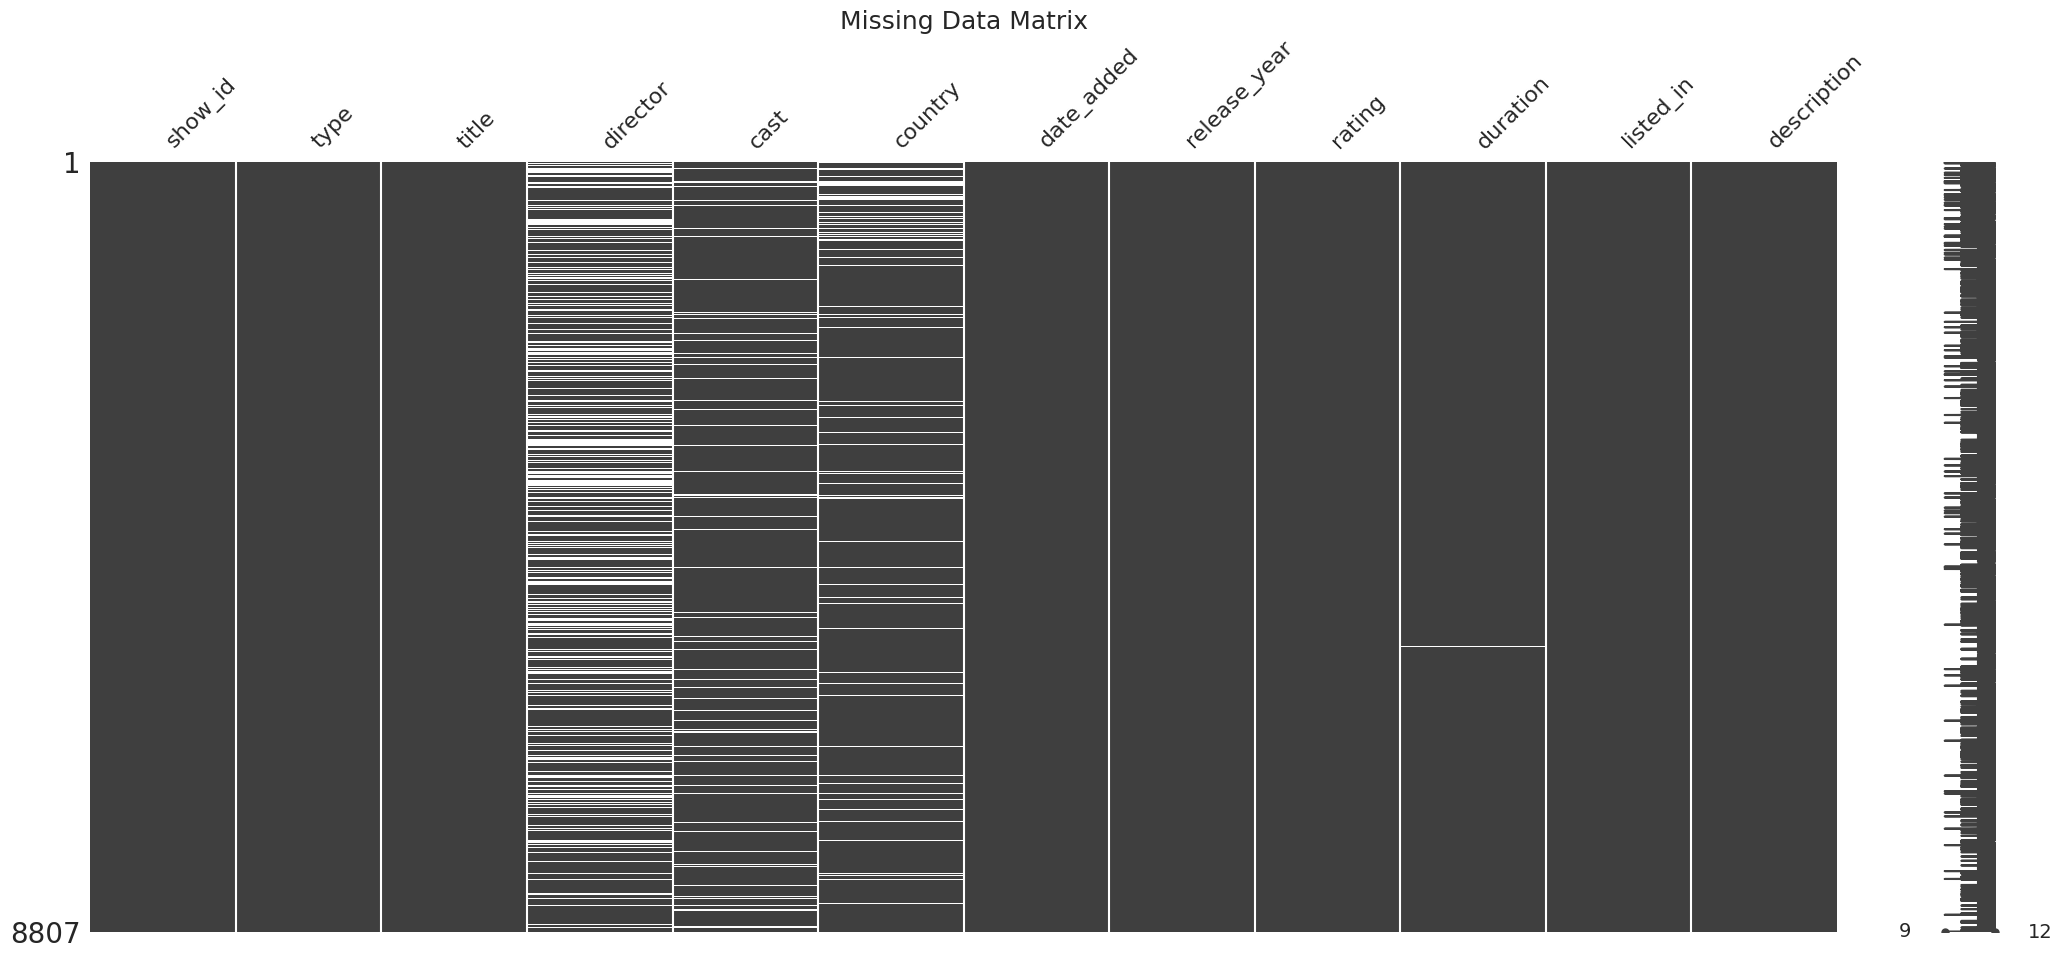


Missing values after cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        3
listed_in       0
description     0
dtype: int64

New shape of the data: (8797, 12)


/tmp/ipython-input-1121815099.py:15: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipython-input-1121815099.py:16: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or

In [ ]:
if 'df' in locals():
    # --- 2.1. Handling Missing Values ---

    # Visualize missing data
    print("\nVisualizing missing data:")
    msno.matrix(df)
    plt.title('Missing Data Matrix', fontsize=18)
    plt.show()

    # Strategy:
    # director, cast, country: Replace NaN with 'Unknown'
    # date_added, rating: These have few missing values. We can either drop them or fill with the mode.
    # Let's fill 'rating' with its mode and drop rows where 'date_added' is null.

    df['director'].fillna('Unknown', inplace=True)
    df['cast'].fillna('Unknown', inplace=True)
    df['country'].fillna('Unknown', inplace=True)

    # Fill 'rating' with the mode
    rating_mode = df['rating'].mode()[0]
    df['rating'].fillna(rating_mode, inplace=True)

    # Drop rows with missing 'date_added'
    df.dropna(subset=['date_added'], inplace=True)

    print("\nMissing values after cleaning:")
    print(df.isnull().sum())
    print(f"\nNew shape of the data: {df.shape}")


In [ ]:

# %%
if 'df' in locals():
    # --- 2.2. Correcting Data Types & Feature Engineering (Temporal) ---

    # Convert 'date_added' to datetime
    df['date_added'] = pd.to_datetime(df['date_added'].str.strip(), format='%B %d, %Y')

    # Extract new temporal features
    df['year_added'] = df['date_added'].dt.year
    df['month_added'] = df['date_added'].dt.month_name()
    df['day_added'] = df['date_added'].dt.day

    # --- 2.3. Feature Engineering (Duration) ---

    # Split 'duration' into value and unit
    df['duration_num'] = df['duration'].apply(lambda x: re.findall(r'\d+', str(x))[0] if re.findall(r'\d+', str(x)) else 0)
    df['duration_unit'] = df['duration'].apply(lambda x: 'Season(s)' if 'Season' in str(x) else ('Min' if 'min' in str(x) else 'Unknown'))

    # Convert duration_num to numeric
    df['duration_num'] = pd.to_numeric(df['duration_num'])

    # --- 2.4. Feature Engineering (Time Lag) ---

    # Ensure 'release_year' and 'year_added' are integers
    df['release_year'] = df['release_year'].astype(int)

    # We already have 'year_added' (it will be float from dt, convert to int)
    df['year_added'] = df['year_added'].astype(int)

    df['time_lag_years'] = df['year_added'] - df['release_year']

    # --- 2.5. Feature Engineering (Geospatial - CRITICAL FIX) ---
    # Create 'first_country' on the main dataframe for all subsequent analysis
    # This was identified as a bug in the previous version
    df['first_country'] = df['country'].apply(lambda x: x.split(',')[0].strip())

    print("\nData after feature engineering:")
    print(df[['date_added', 'year_added', 'month_added', 'duration_num', 'duration_unit', 'time_lag_years', 'first_country']].head())



Data after feature engineering:
  date_added  year_added month_added  duration_num duration_unit  \
0 2021-09-25        2021   September            90           Min   
1 2021-09-24        2021   September             2     Season(s)   
2 2021-09-24        2021   September             1     Season(s)   
3 2021-09-24        2021   September             1     Season(s)   
4 2021-09-24        2021   September             2     Season(s)   

   time_lag_years  first_country  
0               1  United States  
1               0   South Africa  
2               0        Unknown  
3               0        Unknown  
4               0          India  



#3.1.1. Overall Composition: Movies vs. TV Shows


**Composition:** Movies vs. TV Shows.
**Genre:** Popularity and distribution.
**Rating:** Prevalence of different rating categories.
**Volume:** Content volume trends over time.
**Geography:** Geographic distribution of content production.



In [ ]:
if 'df' in locals():
    type_counts = df['type'].value_counts()

    fig = go.Figure(data=[go.Pie(labels=type_counts.index,
                                 values=type_counts.values,
                                 pull=[0, 0.05],
                                 hole=.4,
                                 marker_colors=['#E50914', '#564d4d'],
                                 textfont_size=14)])

    fig.update_layout(title_text='<b>Content Type Distribution: Movies vs. TV Shows</b>',
                      title_x=0.5,
                      annotations=[dict(text='Total', x=0.5, y=0.5, font_size=20, showarrow=False)])

    fig.show()


#**Inference & Strategic Insight:**
#
The Netflix catalog is heavily skewed towards **Movies**, which constitute nearly 70% of the content. However, TV Shows often drive long-term engagement and subscriber retention (the "binge-watching" model).
#
**Strategic Question:** Is this 70/30 split intentional? Does subscriber engagement data show that movies drive new acquisitions while TV shows drive retention? Netflix's recent focus on high-budget original series suggests the *value* of TV shows may be disproportionately higher than their 30% share.


#3.1.2. Rating Categories and Their Prevalence



/tmp/ipython-input-1809443687.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




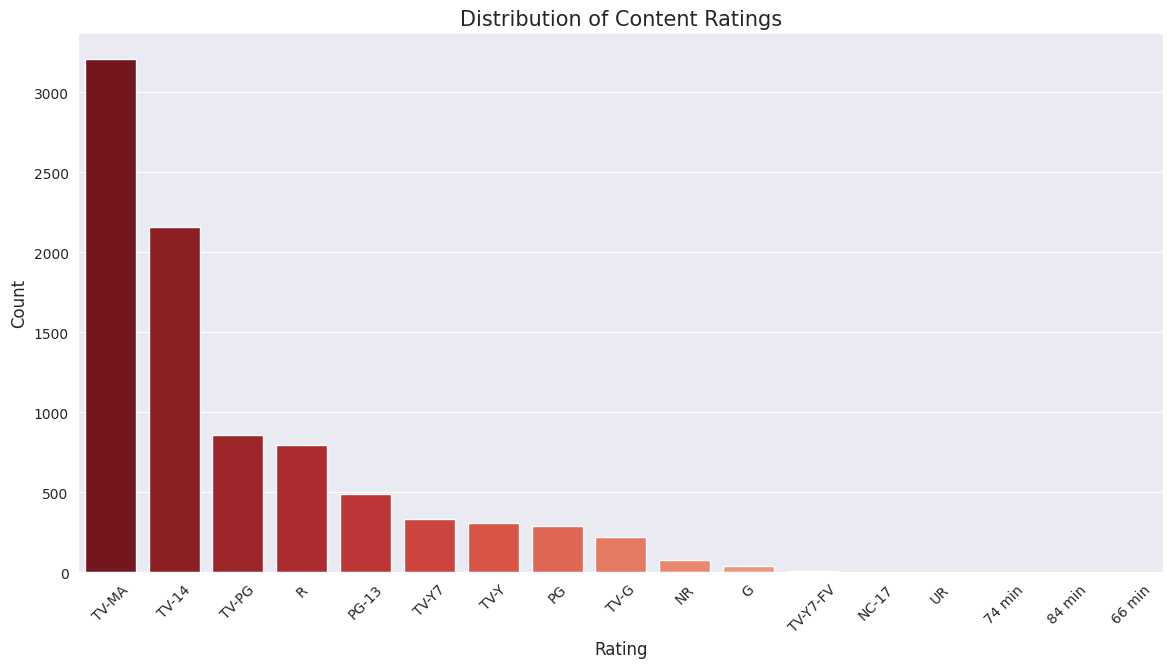

In [ ]:
if 'df' in locals():
    plt.figure(figsize=(14, 7))
    sns.countplot(x='rating', data=df, order=df['rating'].value_counts().index, palette='Reds_r')
    plt.title('Distribution of Content Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

#**Inference & Strategic Insight:**
#
The two most prevalent ratings are **TV-MA** (Mature Audience) and **TV-14** (Parents Strongly Cautioned). This indicates a strong focus on adult and young-adult audiences.
#
**Strategic Insight:** Content for "General Audiences" (G, TV-G, PG, TV-PG) is significantly less common. This could be a strategic gap or a deliberate focus. While competitors like Disney+ dominate the family-friendly market, there might be an untapped opportunity for Netflix to expand its "co-viewing" (family) content, which can be a strong retention tool for households.
#3.1.3. Genre Distribution and Popularity


/tmp/ipython-input-1027396952.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




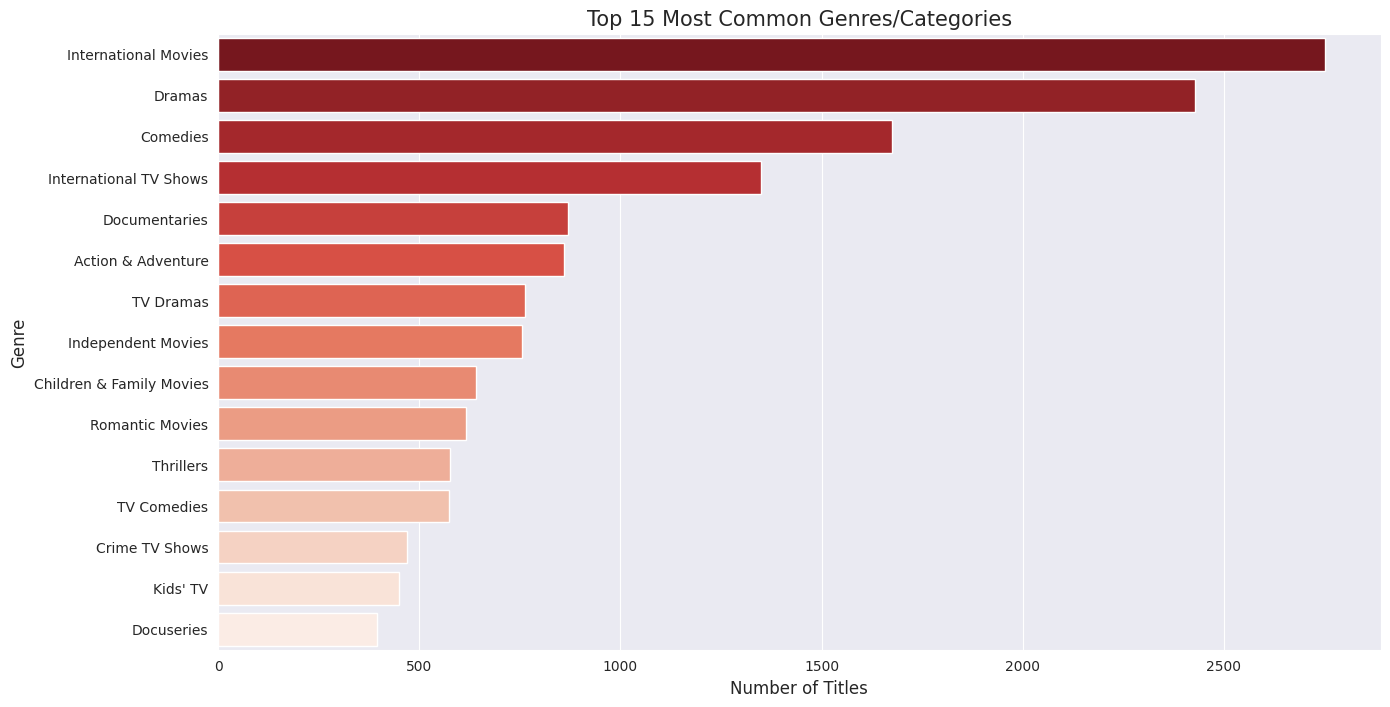

In [ ]:

if 'df' in locals():
    # Helper function to parse and count comma-separated values
    def get_top_n_from_column(column_name, n=10):
        # Split and stack the values
        values = df[column_name].str.split(', ').explode()
        # Clean whitespace
        values = values.str.strip()
        # Get top N value counts
        return values.value_counts().head(n)

    # Get top 10 genres
    top_genres = get_top_n_from_column('listed_in', n=15)

    plt.figure(figsize=(15, 8))
    sns.barplot(x=top_genres.values, y=top_genres.index, palette='Reds_r')
    plt.title('Top 15 Most Common Genres/Categories')
    plt.xlabel('Number of Titles')
    plt.ylabel('Genre')
    plt.show()


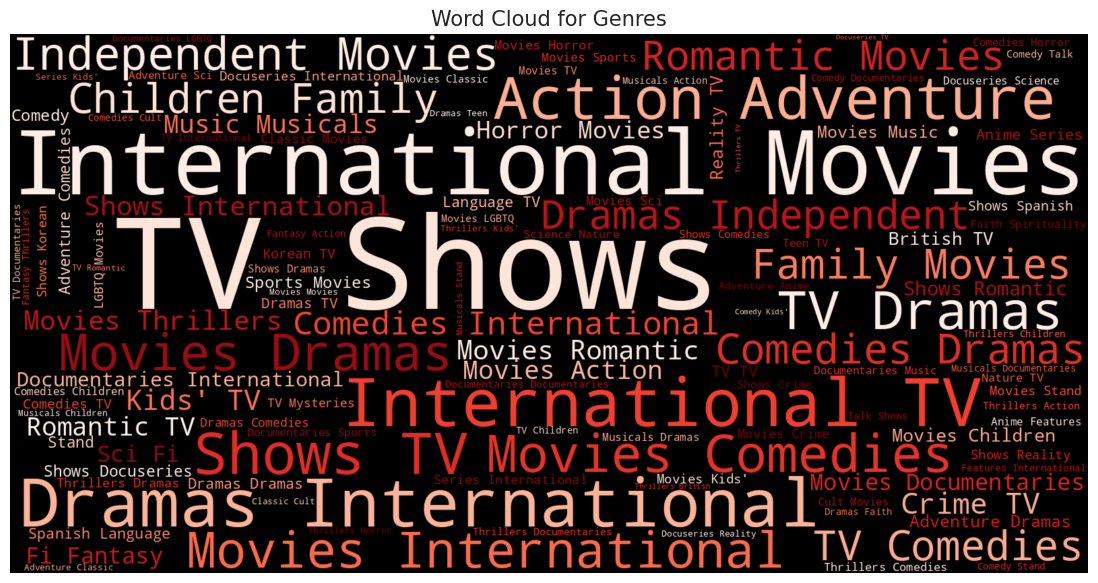

In [ ]:
if 'df' in locals():
    # Word Cloud for Genres
    genre_text = " ".join(genre for genre in df['listed_in'].str.replace(', ', ' '))

    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=STOPWORDS,
                          colormap='Reds',
                          min_font_size=10).generate(genre_text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for Genres')
    plt.show()


#**Inference & Strategic Insight:**
#
The most common categories are **International Movies**, **Dramas**, and **Comedies**. The prominence of "International Movies" is a key strategic finding.
#
**Strategic Insight:** This isn't just a US-centric platform; it's a global one. The data clearly shows a massive investment in international content, which serves two purposes:
1.  Appealing to local audiences in high-growth markets (e.g., India, South Korea, Brazil).
2.  Exporting this content globally (e.g., the "Squid Game" or "Money Heist" phenomenon).
**Recommendation:** Netflix should continue to double down on its "glocal" (global + local) strategy, using its platform to turn local hits into global blockbusters.

#3.1.4. Geographic Distribution of Content Production


/tmp/ipython-input-2946855665.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




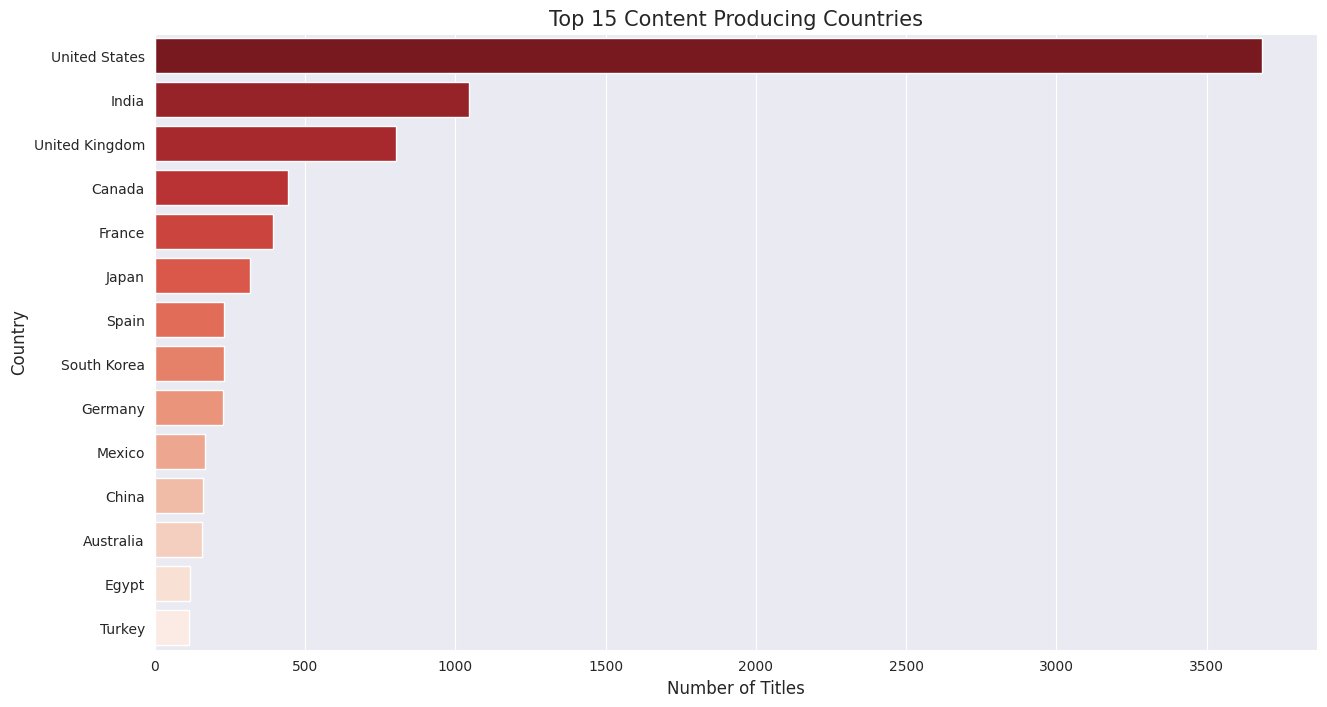

In [ ]:
if 'df' in locals():
    # Get top 15 producing countries
    top_countries = get_top_n_from_column('country', n=15)

    # Remove the 'Unknown' category for this plot
    top_countries = top_countries.drop('Unknown', errors='ignore')

    plt.figure(figsize=(15, 8))
    sns.barplot(x=top_countries.values, y=top_countries.index, palette='Reds_r')
    plt.title('Top 15 Content Producing Countries')
    plt.xlabel('Number of Titles')
    plt.ylabel('Country')
    plt.show()


In [ ]:
if 'df' in locals():
    # Interactive Choropleth Map

    # We can now use the 'first_country' column from the main df
    # (This code is simplified thanks to the fix in Section 2.5)
    df_map = df[df['first_country'] != 'Unknown']

    country_counts = df_map['first_country'].value_counts().reset_index()
    country_counts.columns = ['country', 'count']

    # Standardize some country names for Plotly
    country_counts['country'] = country_counts['country'].replace(
        'United States', 'USA').replace(
        'United Kingdom', 'UK').replace(
        'South Korea', 'South Korea')

    # We need country codes (ISO Alpha-3)
    # A simple mapping for top countries (a robust solution would use a converter library)
    # For a hackathon, we can also let Plotly handle name matching

    fig = px.choropleth(country_counts,
                        locations="country",
                        locationmode='country names',
                        color="count",
                        hover_name="country",
                        hover_data={'count': True},
                        color_continuous_scale=px.colors.sequential.Reds,
                        title="<b>Geographic Distribution of Content Production (based on first country listed)</b>")

    fig.update_layout(title_x=0.5, geo=dict(bgcolor='rgba(0,0,0,0)'))
    fig.show()


#**Inference & Strategic Insight:**
#
The **United States** is, by far, the largest content producer in the catalog. However, **India**, the **United Kingdom**, **Japan**, **South Korea**, and **Canada** are also massive content hubs.
#
**Strategic Insight:** The map clearly visualizes Netflix's two-pronged geographic strategy:
1.  **Dominance:** Maintain a strong, dominant base of US content.
2.  **Strategic Hubs:** Invest heavily in production hubs in key markets (India for Bollywood/regional, South Korea for K-drama, Japan for Anime, UK for high-quality drama/comedy).
**Opportunity:** Regions like South America (Brazil, Argentina) and Africa (Nigeria, South Africa) show significant production but are not yet at the level of India or South Korea. These could be the next major growth frontiers for content acquisition.

## 4. Primary Analysis Task 2: Temporal Trend Analysis
#
This section explores how the Netflix catalog has evolved over time.
#
**Catalog Growth:** How quickly has the catalog expanded?
**Addition Patterns:** Are there seasonal trends for adding content?
**Strategy Shift:** How has the mix of Movies vs. TV Shows changed?
**Content Aging:** What is the lag between a title's release and its addition to Netflix?

#4.1. Netflix Catalog Growth Over the Years (by Date Added)

In [ ]:
if 'df' in locals():
    # Content added per year
    content_added_yearly = df.groupby('year_added')['show_id'].count().reset_index()

    # Content type added per year
    content_type_yearly = df.groupby(['year_added', 'type'])['show_id'].count().unstack().fillna(0)

    fig = go.Figure()

    # Add traces for Movie and TV Show
    fig.add_trace(go.Scatter(x=content_type_yearly.index,
                             y=content_type_yearly['Movie'],
                             mode='lines+markers',
                             name='Movies Added',
                             line=dict(color='#E50914', width=3)))

    fig.add_trace(go.Scatter(x=content_type_yearly.index,
                             y=content_type_yearly['TV Show'],
                             mode='lines+markers',
                             name='TV Shows Added',
                             line=dict(color='#564d4d', width=3)))

    fig.update_layout(title='<b>Netflix Content Additions Per Year</b>',
                      title_x=0.5,
                      xaxis_title='Year Added to Netflix',
                      yaxis_title='Number of Titles Added',
                      legend_title='Content Type')

    # Add a vertical line for the 2016 "pivot"
    fig.add_vline(x=2016, line_width=2, line_dash="dash", line_color="green",
                  annotation_text="Start of Aggressive Expansion",
                  annotation_position="top left")

    fig.show()



# **Inference & Strategic Insight:**
#
The chart shows a clear **strategic inflection point around 2016-2017**. Content additions exploded, peaking in 2019. The slight dip in 2020-2021 could be due to the dataset's cutoff date or the real-world impact of the COVID-19 pandemic on content production pipelines.
#
**Strategic Insight:** This visualization pinpoints the moment Netflix went from being a *distributor* to a *dominant global producer* and *acquirer* of content. The rapid increase in TV show additions starting in 2016 is particularly notable, aligning with their push for high-retention original series.


#4.2. Content Addition Patterns (Monthly/Seasonal)


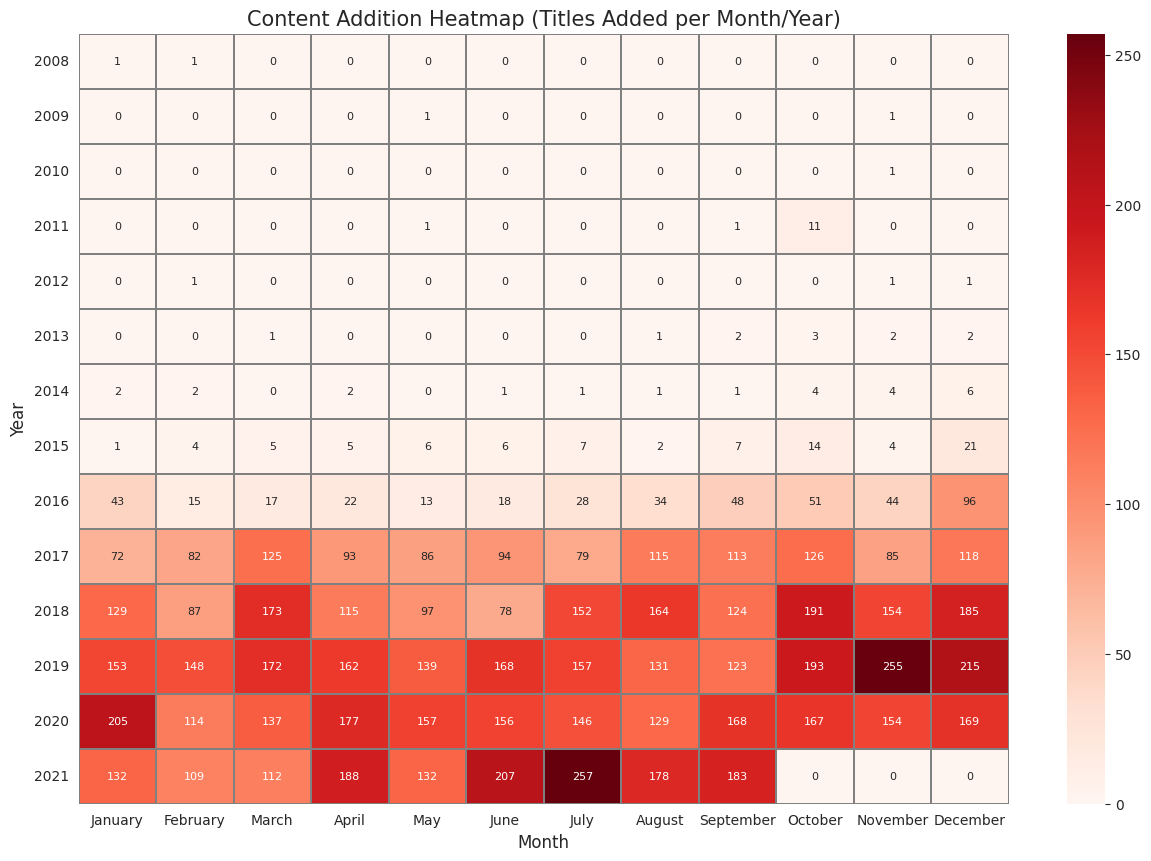

In [ ]:
if 'df' in locals():
    # Order for months
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']

    month_counts = df.groupby(['year_added', 'month_added'])['show_id'].count().reset_index()

    # Pivot for heatmap
    month_pivot = month_counts.pivot(index='year_added', columns='month_added', values='show_id').fillna(0)
    month_pivot = month_pivot.reindex(columns=month_order) # Ensure correct month order

    plt.figure(figsize=(15, 10))
    sns.heatmap(month_pivot, cmap='Reds', linecolor='grey', linewidths=0.1,
                annot=True, fmt=".0f", annot_kws={"size": 8})
    plt.title('Content Addition Heatmap (Titles Added per Month/Year)')
    plt.xlabel('Month')
    plt.ylabel('Year')
    plt.yticks(rotation=0)
    plt.show()



# **Inference & Strategic Insight:**
#
The heatmap reveals strong seasonal patterns.
#
**Peak Periods:** Content additions seem to peak in two main phases:
1.  **Year-End (Oct-Dec):** A significant ramp-up, likely to capture holiday audiences and "for your consideration" awards season viewers.
2.  **Mid-Year (Jun-Jul):** Another spike, possibly targeting summer vacation/blockbuster season.
**Strategic Insight:** This isn't random; it's a deliberate content-loading strategy. The Q4 push is classic media strategy. The dip in February/March is also consistent. Netflix could potentially "counter-program" by launching a major title in a "quiet" month like February to completely dominate the conversation.

#4.3. Content Aging: Release Year vs. Addition Year Analysis

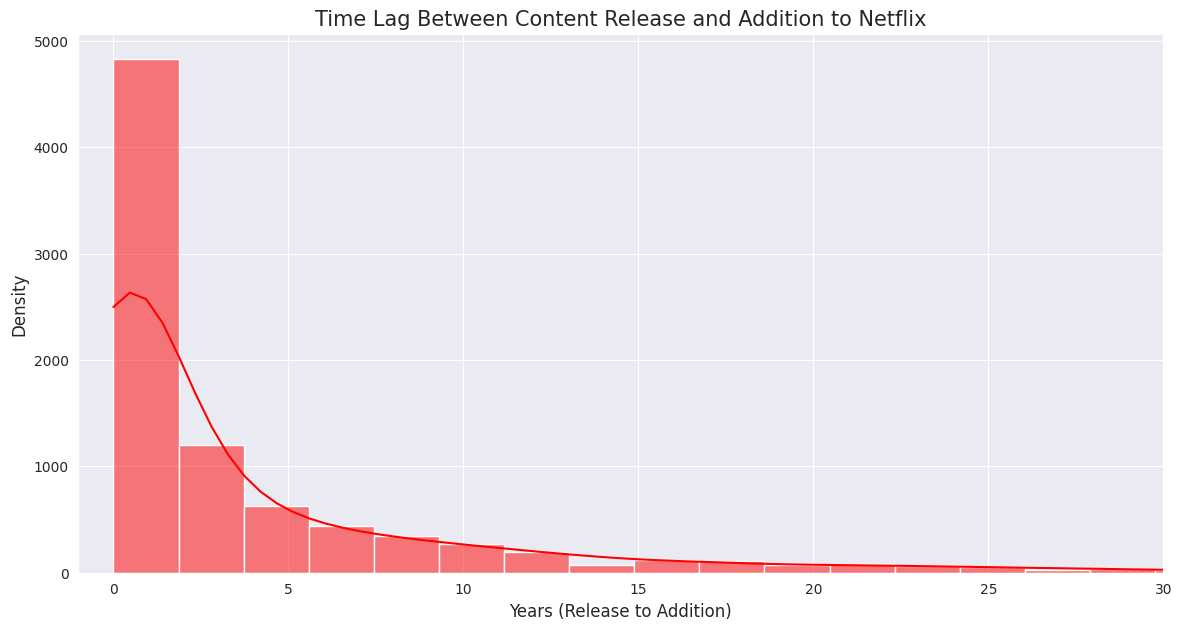


Average time lag: 4.70 years
Median time lag: 1.00 years
Percentage of content added in the same year it was released (lag=0): 36.90%


In [ ]:
if 'df' in locals():
    # We already created 'time_lag_years'
    # Filter out negative lag (content added before its release year - likely data errors or early previews)
    positive_lag = df[df['time_lag_years'] >= 0]

    plt.figure(figsize=(14, 7))
    sns.histplot(positive_lag['time_lag_years'], bins=50, kde=True, color='red')
    plt.title('Time Lag Between Content Release and Addition to Netflix')
    plt.xlabel('Years (Release to Addition)')
    plt.ylabel('Density')
    plt.xlim(-1, 30) # Focus on the 0-30 year lag
    plt.show()

    print(f"\nAverage time lag: {positive_lag['time_lag_years'].mean():.2f} years")
    print(f"Median time lag: {positive_lag['time_lag_years'].median():.2f} years")
    print(f"Percentage of content added in the same year it was released (lag=0): {len(positive_lag[positive_lag['time_lag_years'] == 0]) / len(positive_lag) * 100:.2f}%")



# **Inference & Strategic Insight:**
#
The histogram shows two distinct strategies:
#
1.  **"New & Original" (Spike at 0):** A very large portion of content (over 30%) is added in the *same year* it's released. This represents Netflix Originals and "day-and-date" acquisitions. This is their strategy to be a primary, timely source of new content.
2.  **"Catalog/Library" (Long Tail):** The long tail shows Netflix's other role as a library, acquiring content that is 2, 5, 10, or even 20+ years old. This is crucial for satisfying "mood" viewing and appealing to nostalgia.
#
**Strategic Insight:** Netflix is successfully balancing being a cutting-edge studio (the spike at 0) and a deep, comfortable library (the long tail). The median lag of ~1 year confirms a strong bias towards fresh content.



#5. Primary Analysis Task 3: Geographic Content Analysis
#
This section dives deeper into the "where" of content.
#
**Top Producers:** Who makes the most content?
**Content Ratio:** International vs. Domestic (US).
**Regional Preferences:** What genres do different countries specialize in?


#5.1. International vs. Domestic (US) Content Ratio Over Time


In [ ]:
if 'df' in locals():
    # We'll use the 'first_country' column created earlier
    df['is_us'] = df['first_country'].apply(lambda x: 'USA' if x == 'United States' else ('Unknown' if x == 'Unknown' else 'Non-USA'))

    # Exclude 'Unknown'
    df_geo_trends = df[df['is_us'] != 'Unknown']

    geo_trends = df_geo_trends.groupby(['year_added', 'is_us'])['show_id'].count().unstack().fillna(0)

    # Calculate percentage
    geo_trends_pct = geo_trends.apply(lambda x: x / x.sum(), axis=1)

    fig = go.Figure()

    fig.add_trace(go.Bar(x=geo_trends_pct.index,
                         y=geo_trends_pct['USA'],
                         name='USA Content',
                         marker_color='#564d4d'))

    fig.add_trace(go.Bar(x=geo_trends_pct.index,
                         y=geo_trends_pct['Non-USA'],
                         name='International Content',
                         marker_color='#E50914'))

    fig.update_layout(barmode='stack',
                      title='<b>Proportion of US vs. International Content Added Per Year</b>',
                      title_x=0.5,
                      xaxis_title='Year Added',
                      yaxis_title='Percentage of Content Added',
                      yaxis_tickformat='%',
                      legend_title='Origin')
    fig.show()


# **Inference & Strategic Insight:**
#
This is one of the most important charts for understanding Netflix's strategy.
#
**The Great Shift:** Before 2015, the catalog was overwhelmingly American (70-80%+). Starting in 2016-2017, the proportion of **Non-USA (International) content began to rapidly increase**.
**Global-First:** By 2018, international content additions surpassed US additions, and by 2021, they represented over 60% of new additions.
#
**Strategic Insight:** This visualizes Netflix's deliberate, aggressive pivot to becoming a *global* platform. This strategy is essential for growth, as US market saturation increases. The future of Netflix's subscriber growth is international, and its content strategy reflects this reality.


# 5.2. Country-Specific Genre Preferences (Specialization)


In [ ]:

if 'df' in locals():
    # Let's analyze the top 5 countries: USA, India, UK, Japan, South Korea
    top_5_countries = ['United States', 'India', 'United Kingdom', 'Japan', 'South Korea']

    # We need to "explode" both country and genre
    df_exploded = df.assign(country=df['country'].str.split(', '),
                            genre=df['listed_in'].str.split(', ')).explode('country').explode('genre')

    df_exploded['country'] = df_exploded['country'].str.strip()
    df_exploded['genre'] = df_exploded['genre'].str.strip()

    # Filter for top 5 countries
    df_top5 = df_exploded[df_exploded['country'].isin(top_5_countries)]

    # Get top 5 genres for each country
    top_genres_by_country = df_top5.groupby('country')['genre'].value_counts()

    # Prepare data for plotting
    plot_data = []
    for country in top_5_countries:
        top_5_for_country = top_genres_by_country[country].head(5).reset_index()
        top_5_for_country['country'] = country
        plot_data.append(top_5_for_country)

    df_plot = pd.concat(plot_data)

    fig = px.bar(df_plot,
                 x='count',
                 y='genre',
                 color='country',
                 barmode='group',
                 facet_col='country',
                 title='<b>Top 5 Genres by Top 5 Producing Countries</b>',
                 labels={'count': 'Number of Titles', 'genre': 'Genre'},
                 height=600)

    # Clean up facet titles
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
    fig.update_yaxes(matches=None, showticklabels=True)
    fig.update_layout(title_x=0.5)

    fig.show()



# **Inference & Strategic Insight:**
#
The chart clearly shows strong national genre specializations, confirming Netflix is acquiring content that plays to each country's strengths.
#
**USA:** Strong in **Dramas** and **Comedies** (mainstream) but "Documentaries" are surprisingly high.
**India:** Absolutely dominated by **International Movies**, followed by **Dramas** and **Comedies**. This reflects the massive Bollywood and regional film industries.
**UK:** Specializes in **Dramas**, **International Movies**, and **Comedies**, but also **British TV Shows** (a strong global brand) and **Documentaries**.
**Japan:** Completely dominated by **Anime** and **International Movies**.
**South Korea:** Dominated by **International TV Shows** and **K-dramas** (listed as "TV Shows").
#
**Strategic Insight:** Netflix's acquisition strategy is not "one size fits all." It's a highly-specialized "portfolio" approach. They go to Japan for Anime, South Korea for K-dramas, and India for feature films. This maximizes quality and authenticity, appealing to local audiences first and then leveraging global "crossover" hits.



#6. Primary Analysis Task 4: Genre & Category Intelligence
#
This section explores the "what" of the catalog.
#
**Co-occurrence:** Which genres are commonly listed together?
**Evolution:** How have genre preferences changed over time?
**Correlations:** How do genres and ratings relate?


#6.1. Cross-Genre Analysis (Co-occurrence Matrix)


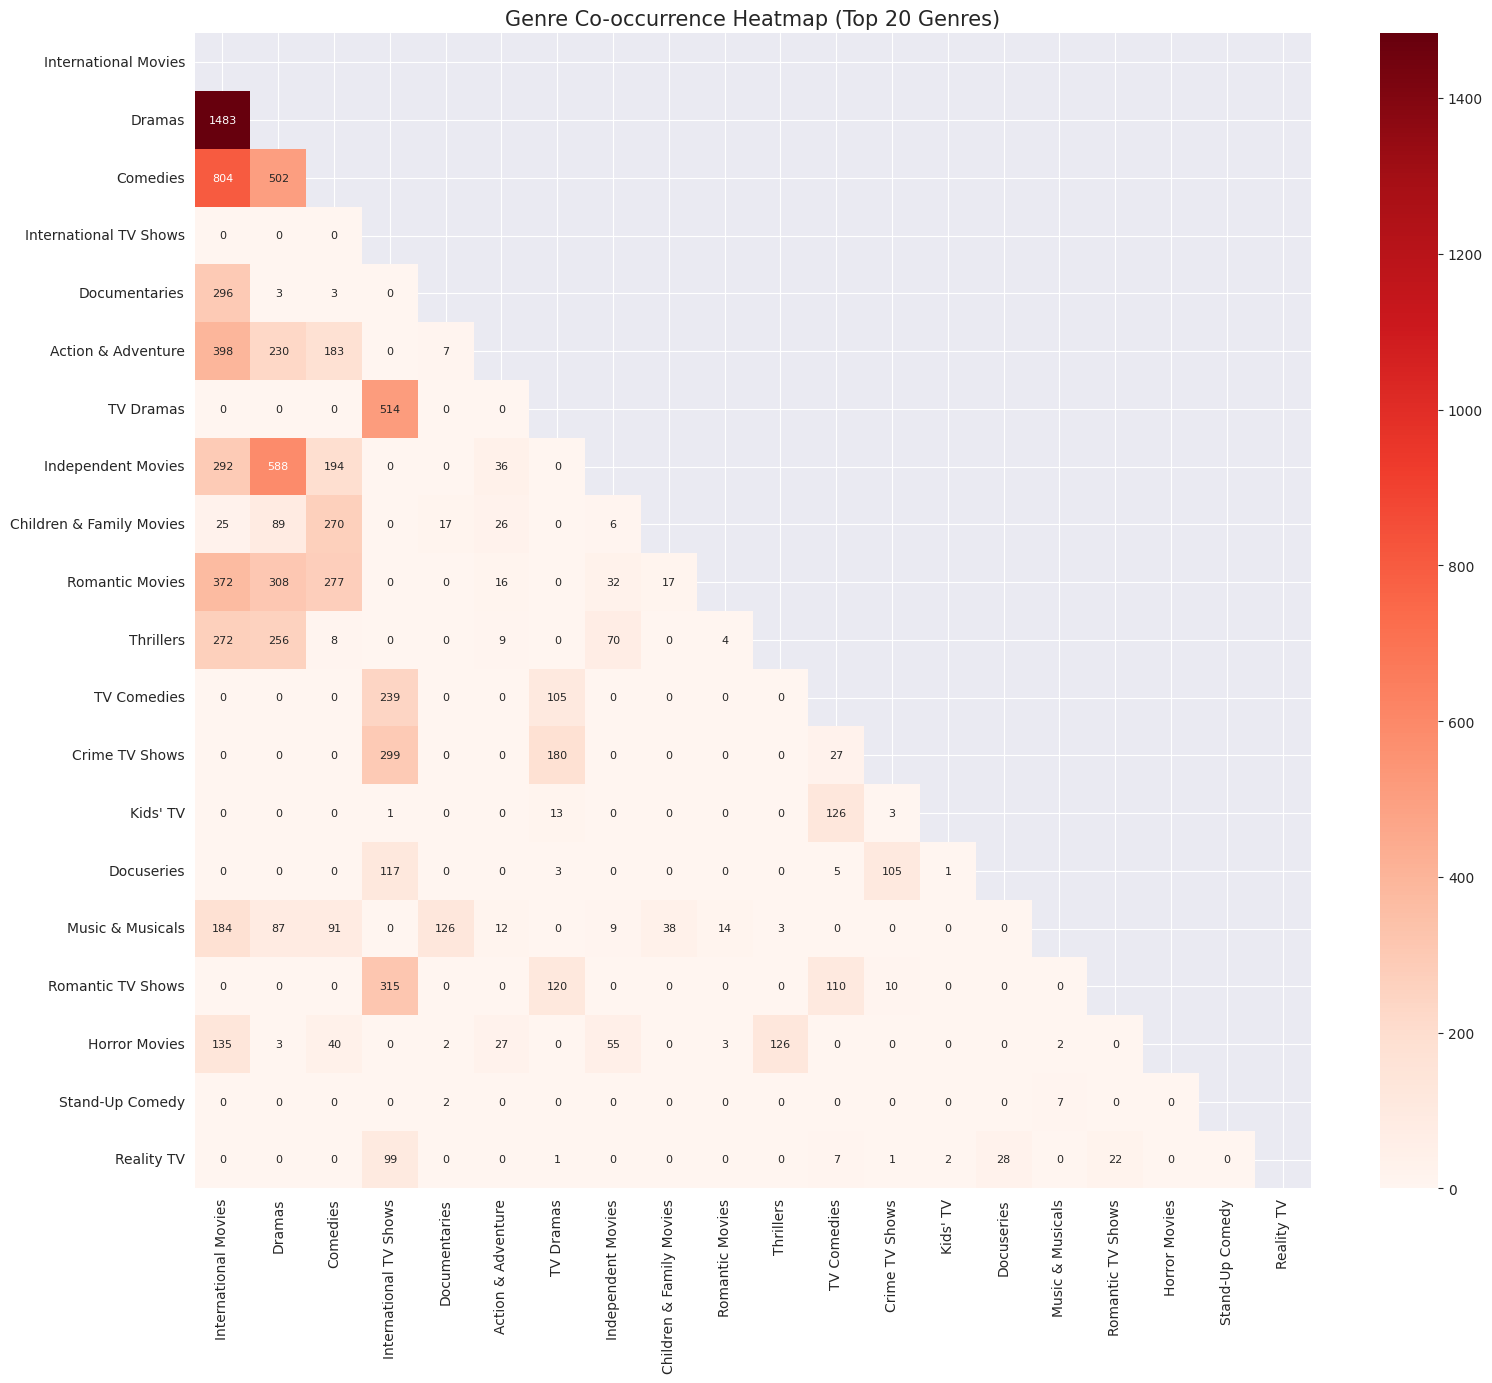

In [ ]:
if 'df' in locals():
    from sklearn.preprocessing import MultiLabelBinarizer

    # Get genres, splitting and stripping
    genres = df['listed_in'].apply(lambda x: [g.strip() for g in x.split(',')])

    # Use MultiLabelBinarizer to one-hot encode the genres
    mlb = MultiLabelBinarizer()
    genre_encoded = mlb.fit_transform(genres)
    genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

    # Get top 20 genres for readability
    top_20_genres = genre_df.sum().sort_values(ascending=False).head(20).index
    genre_df_top20 = genre_df[top_20_genres]

    # Calculate co-occurrence matrix (A.T * A)
    co_occurrence_matrix = genre_df_top20.T.dot(genre_df_top20)

    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(co_occurrence_matrix, dtype=bool))

    plt.figure(figsize=(18, 15))
    sns.heatmap(co_occurrence_matrix, mask=mask, cmap='Reds', annot=True, fmt='d',
                xticklabels=top_20_genres, yticklabels=top_20_genres,
                annot_kws={"size": 8})
    plt.title('Genre Co-occurrence Heatmap (Top 20 Genres)')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()



# **Inference & Strategic Insight:**
#
This heatmap shows which genres are frequently "tagged" together.
#
**Strong Pairs:**
**International Movies** has strong overlaps with **Dramas** and **Comedies**. This is the bulk of the catalog.
**Dramas** and **Independent Movies** are strongly linked.
**Kids & Family Movies** and **Children & Family Movies** are near-perfectly correlated (likely a data-tagging consistency issue).
#
**Niche Clusters:**
**Anime Features** and **Anime Series** form their own cluster.
**TV Thrillers** and **TV Dramas** are closely related.
#
**Strategic Insight:** This map can inform recommendation engines. A user who finishes an "International" "Drama" is highly likely to be interested in another "International Movie" or a "Drama." It also highlights opportunities. For example, there's a weaker link between "Comedies" and "Sci-Fi & Fantasy." A successful "Sci-Fi Comedy" could be a "blue ocean" opportunity, tapping into two large but separate-seeming audiences.



#6.2. Genre-Rating Correlations

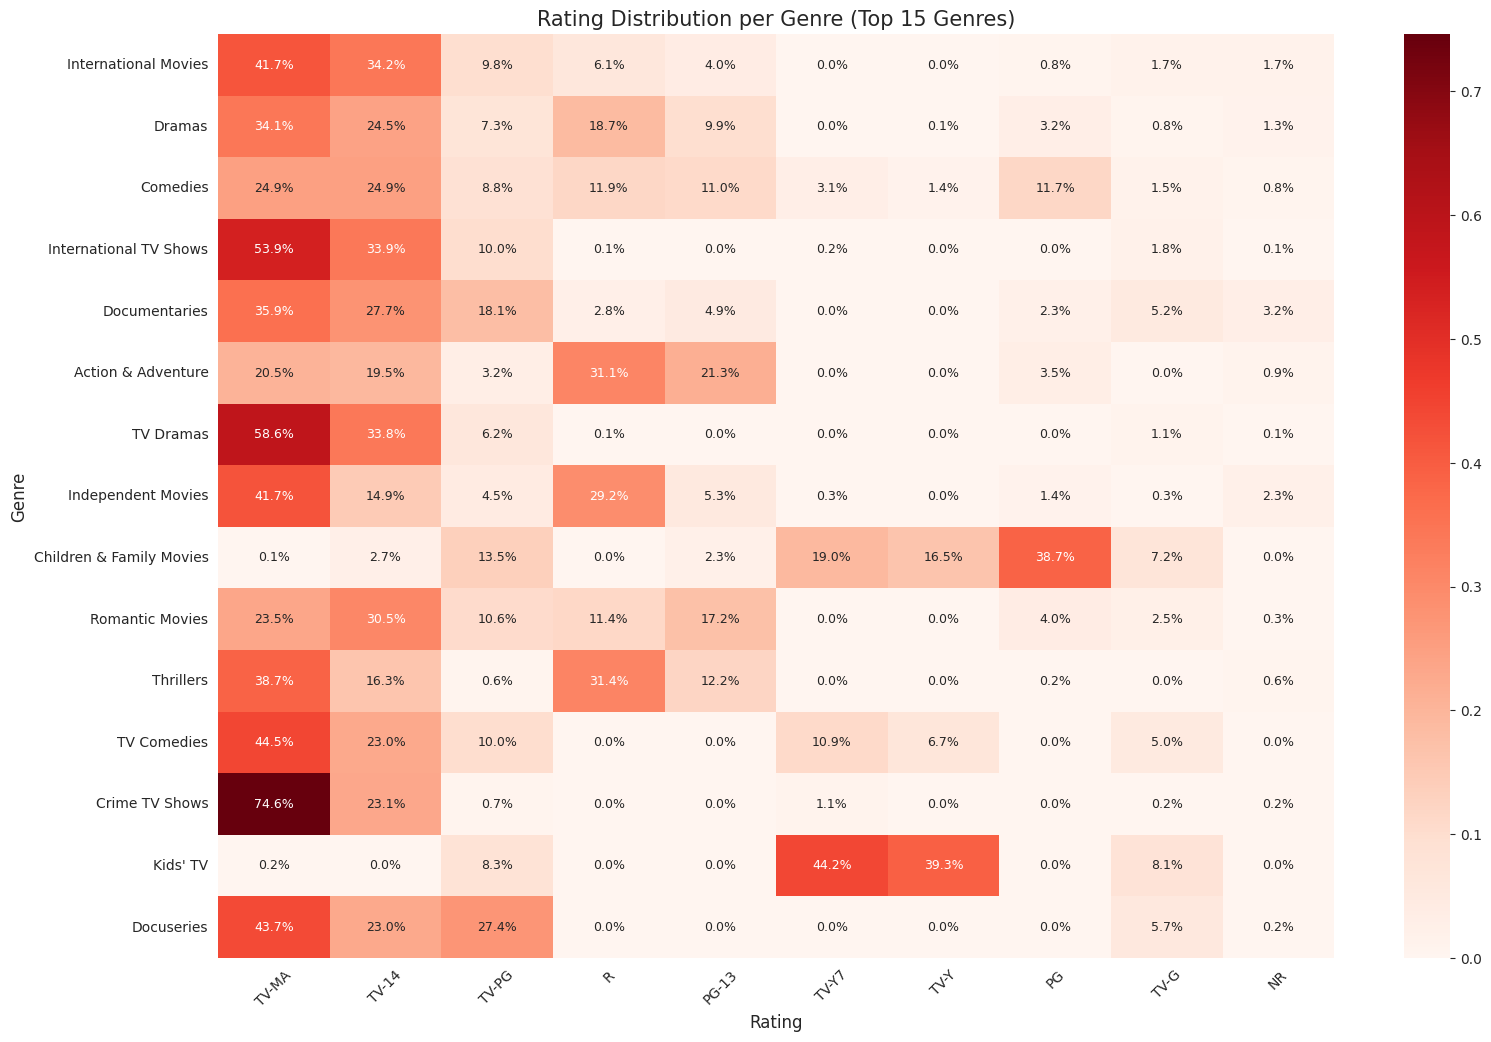

In [ ]:
if 'df' in locals():
    # Use the exploded dataframe from earlier
    genre_rating = df_exploded.groupby(['genre', 'rating'])['show_id'].count().unstack().fillna(0)

    # Filter for top genres and top ratings for readability
    top_genres_list = top_genres.index[:15]
    top_ratings_list = df['rating'].value_counts().index[:10]

    genre_rating_filtered = genre_rating.loc[top_genres_list].T.loc[top_ratings_list].T

    # Normalize by row (genre) to see percentage distribution
    genre_rating_pct = genre_rating_filtered.apply(lambda x: x / x.sum(), axis=1)

    plt.figure(figsize=(18, 12))
    sns.heatmap(genre_rating_pct, cmap='Reds', annot=True, fmt=".1%",
                annot_kws={"size": 9})
    plt.title('Rating Distribution per Genre (Top 15 Genres)')
    plt.xlabel('Rating')
    plt.ylabel('Genre')
    plt.xticks(rotation=45)
    plt.show()


# **Inference & Strategic Insight:**
#
This heatmap reveals clear "target-audience" strategies for each genre.
#
**Mature Genres:** **Horror Movies**, **Thrillers**, and **TV Dramas** are dominated by the **TV-MA** (Mature) rating.
**Broad Appeal:** **Comedies** and **Dramas** have a wider distribution but still lean heavily toward **TV-MA** and **TV-14**.
**Niche Targeting:**
**Anime** is almost exclusively **TV-14** and **TV-MA**.
**Children & Family Movies** are, as expected, **TV-G**, **TV-Y**, and **TV-PG**.
#
**Strategic Insight:** Netflix is not trying to make all content "family-friendly." It's strategically targeting the adult/young-adult demographic (TV-MA, TV-14) that drives subscriptions. The "Kids" profile is a separate, sandboxed experience, and this data shows the "main" platform is built for mature viewers.



#7. Primary Analysis Task 5: Content Creator Analysis
#
This section looks at the people behind the content.
#
* **Prolific Directors:** Who directs the most content?
* **Frequent Cast:** Which actors appear most often?


### 7.1. Most Prolific Directors


/tmp/ipython-input-3157685954.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




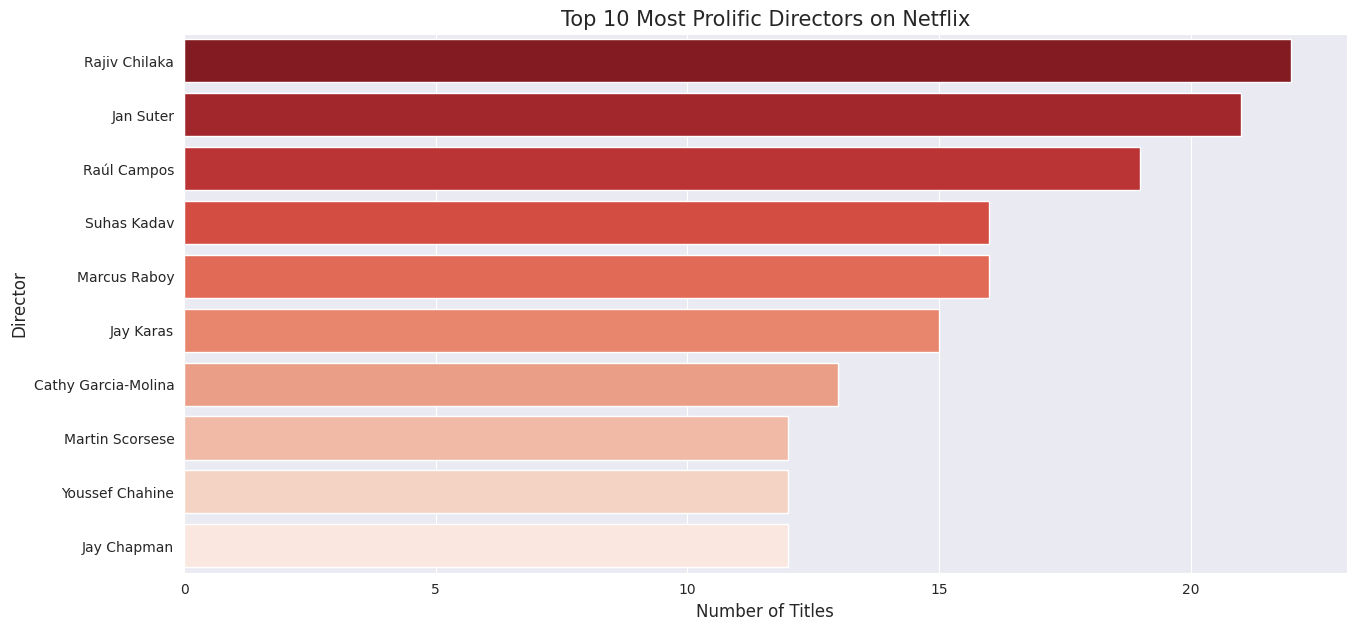

In [ ]:
if 'df' in locals():
    # Use the helper function, excluding 'Unknown'
    top_directors = get_top_n_from_column('director', n=11)
    top_directors = top_directors.drop('Unknown', errors='ignore')

    plt.figure(figsize=(15, 7))
    sns.barplot(x=top_directors.values, y=top_directors.index, palette='Reds_r')
    plt.title('Top 10 Most Prolific Directors on Netflix')
    plt.xlabel('Number of Titles')
    plt.ylabel('Director')
    plt.show()

# **Inference & Strategic Insight:**
#
The list of top directors is revealing. It's not the typical "Hollywood A-list" (Spielberg, Scorsese).
#
**Diverse Hubs:** The names (Rajiv Chilaka, Jan Suter, Raúl Campos) suggest a focus on prolific creators from specific hubs:
* **Rajiv Chilaka:** Creator of "Chhota Bheem," indicating a massive acquisition of Indian children's content.
* **Raúl Campos & Jan Suter:** Directors of many stand-up comedy specials, particularly from Mexico.
* **Marcus Raboy:** Also known for comedy specials.
#
**Strategic Insight:** Netflix's "creator" strategy isn't just about big-budget deals with a few Hollywood elites. It's also a high-volume, "scale" strategy:
1.  **Comedy Specials:** These are (relatively) cheap and fast to produce and are highly repeatable, building a deep library.
2.  **Children's Content:** Acquiring the *entire library* of a prolific creator like Rajiv Chilaka instantly creates a huge, sticky "Kids" catalog.



#7.2. Most Frequent Cast Members

/tmp/ipython-input-1214683477.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




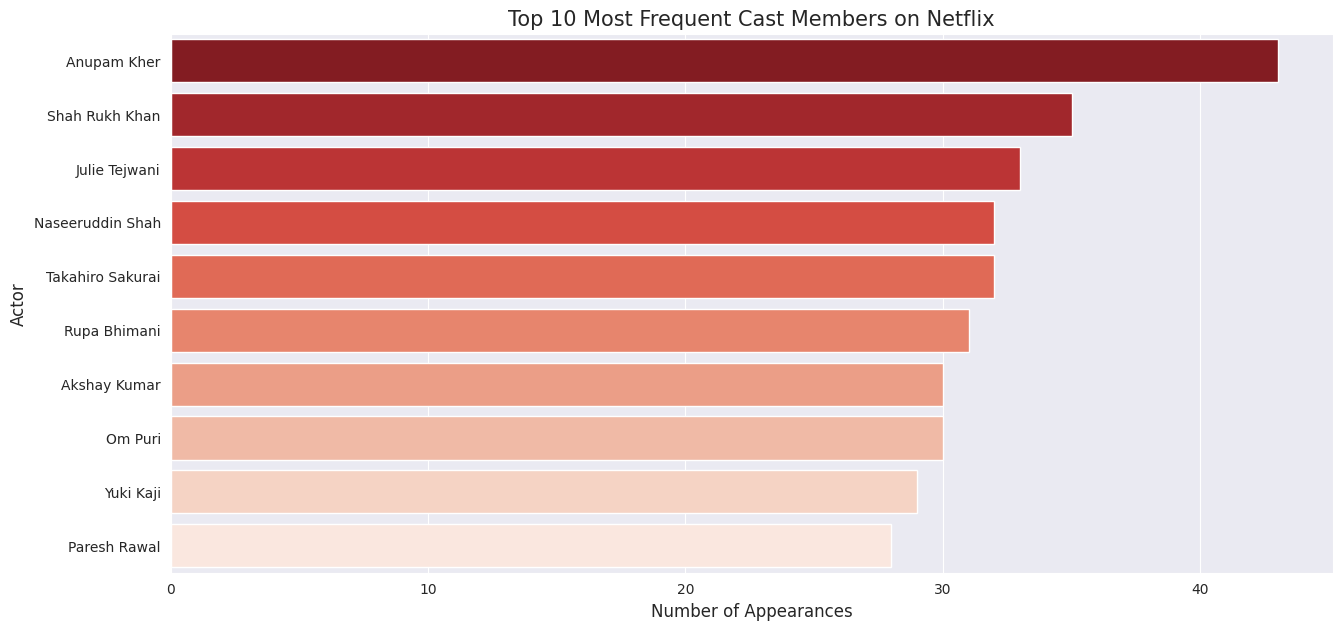

In [ ]:
if 'df' in locals():
    # Use the helper function, excluding 'Unknown'
    top_cast = get_top_n_from_column('cast', n=11)
    top_cast = top_cast.drop('Unknown', errors='ignore')

    plt.figure(figsize=(15, 7))
    sns.barplot(x=top_cast.values, y=top_cast.index, palette='Reds_r')
    plt.title('Top 10 Most Frequent Cast Members on Netflix')
    plt.xlabel('Number of Appearances')
    plt.ylabel('Actor')
    plt.show()

# **Inference & Strategic Insight:**
#
Similar to the directors, the top cast list is dominated by actors from **India**.
#
* **Bollywood Dominance:** Anupam Kher, Shah Rukh Khan, Akshay Kumar, etc., are all Bollywood superstars. Their high frequency is a direct result of Netflix's major investment in its Indian content library.
#
* **Strategic Insight:** This again reinforces the **global strategy**. To win the Indian market, Netflix *must* have the biggest stars. This list shows they are succeeding in acquiring this "must-have" content. The presence of Adam Sandler (not on this top 10 but often high up) would represent the "US prolific creator" strategy, where Netflix signs exclusive, multi-film deals with bankable stars.


#8. Primary Analysis Task 6: Rating & Audience Targeting
#
This section was partially covered in 3.1.2 and 6.2. We will add one more analysis: the evolution of rating strategy over time.*


###8.1. Evolution of Rating Strategy Over Time

In [ ]:
if 'df' in locals():
    # Group ratings into broader categories
    def group_ratings(rating):
        if rating in ['TV-MA', 'R', 'NC-17']:
            return 'Adult (MA/R)'
        elif rating in ['TV-14', 'PG-13']:
            return 'Teens (13+/14+)'
        elif rating in ['TV-PG', 'PG', 'TV-G', 'G', 'TV-Y', 'TV-Y7']:
            return 'Family (G/PG/Y)'
        else:
            return 'Other/Unrated'

    df['rating_group'] = df['rating'].apply(group_ratings)

    rating_trends = df.groupby(['year_added', 'rating_group'])['show_id'].count().unstack().fillna(0)
    rating_trends_pct = rating_trends.apply(lambda x: x / x.sum(), axis=1)

    fig = go.Figure()

    # Plot as stacked area chart
    fig.add_trace(go.Scatter(x=rating_trends_pct.index,
                             y=rating_trends_pct['Adult (MA/R)'],
                             mode='lines', name='Adult (MA/R)',
                             stackgroup='one', line=dict(color='#E50914')))

    fig.add_trace(go.Scatter(x=rating_trends_pct.index,
                             y=rating_trends_pct['Teens (13+/14+)'],
                             mode='lines', name='Teens (13+/14+)',
                             stackgroup='one', line=dict(color='#ab1a1a')))

    fig.add_trace(go.Scatter(x=rating_trends_pct.index,
                             y=rating_trends_pct['Family (G/PG/Y)'],
                             mode='lines', name='Family (G/PG/Y)',
                             stackgroup='one', line=dict(color='#564d4d')))

    fig.update_layout(title='<b>Evolution of Content Rating Strategy Over Time (Proportional)</b>',
                      title_x=0.5,
                      xaxis_title='Year Added',
                      yaxis_title='Percentage of Content Added',
                      yaxis_tickformat='%',
                      hovermode='x unified')
    fig.show()



# **Inference & Strategic Insight:**
#
This stacked area chart clearly shows how Netflix's target audience has "matured."
#
**The "Adult" Shift:** In the early 2010s, "Family" and "Teens" content made up a much larger portion of additions (over 60% combined).
**Post-2016:** Coinciding with the aggressive expansion, the **"Adult (MA/R)"** category has grown dramatically, now consistently making up nearly 50% of all new content. The "Teens (13+/14+)" category has also remained very strong.
#
**Strategic Insight:** Netflix is solidifying its brand as a platform for **adults and young adults**. While "Family" content remains a stable, necessary-but-small portion, the clear growth engine is content for mature audiences. This strategy differentiates them from Disney+ and attracts subscribers willing to pay for premium, adult-oriented dramas, thrillers, and comedies.



#9. Primary Analysis Task 7: Duration & Format Analysis
#
This section analyzes the *length* of content.
#
* **Movie Length:** What is the typical movie duration?
* **TV Show Seasons:** How many seasons do shows typically have?
* **Genre/Duration:** Do different genres have different lengths?


### 9.1. Movie Length Distributions

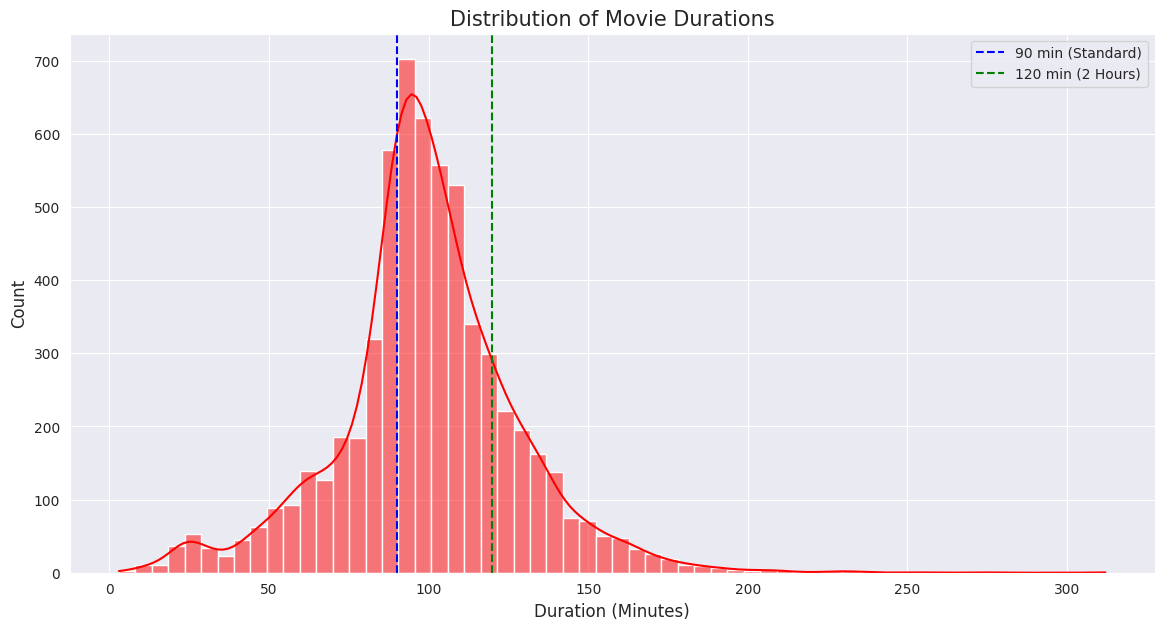


Average movie duration: 99.58 minutes
Median movie duration: 98.00 minutes


In [ ]:
if 'df' in locals():
    # Filter for movies with a valid duration
    df_movies = df[(df['type'] == 'Movie') & (df['duration_unit'] == 'Min') & (df['duration_num'] > 0)]

    plt.figure(figsize=(14, 7))
    sns.histplot(df_movies['duration_num'], bins=60, kde=True, color='red')
    plt.title('Distribution of Movie Durations')
    plt.xlabel('Duration (Minutes)')
    plt.ylabel('Count')

    # Add lines for common durations
    plt.axvline(90, color='blue', linestyle='--', label='90 min (Standard)')
    plt.axvline(120, color='green', linestyle='--', label='120 min (2 Hours)')

    plt.legend()
    plt.show()

    print(f"\nAverage movie duration: {df_movies['duration_num'].mean():.2f} minutes")
    print(f"Median movie duration: {df_movies['duration_num'].median():.2f} minutes")


# **Inference & Strategic Insight:**
#
The distribution shows a clear peak around **90-100 minutes**. This is the classic, commercially-safe runtime for a feature film.
#
* **Noteworthy:** There is a significant "shoulder" between 110 and 130 minutes, representing the more "epic" or "blockbuster" films. There's also a small, distinct cluster on the far left (under 40 mins), which likely represents short films and some documentaries.
#
* **Strategic Insight:** The 90-minute sweet spot is ideal for streaming. It's a low-commitment "click-and-play" for a weeknight. Unlike theaters, where "epic" 3-hour films can be an event, streaming may favor shorter, "snackable" feature content. The data shows Netflix heavily invests in this standard runtime.



# 9.2. TV Show Season Patterns


/tmp/ipython-input-1433583220.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




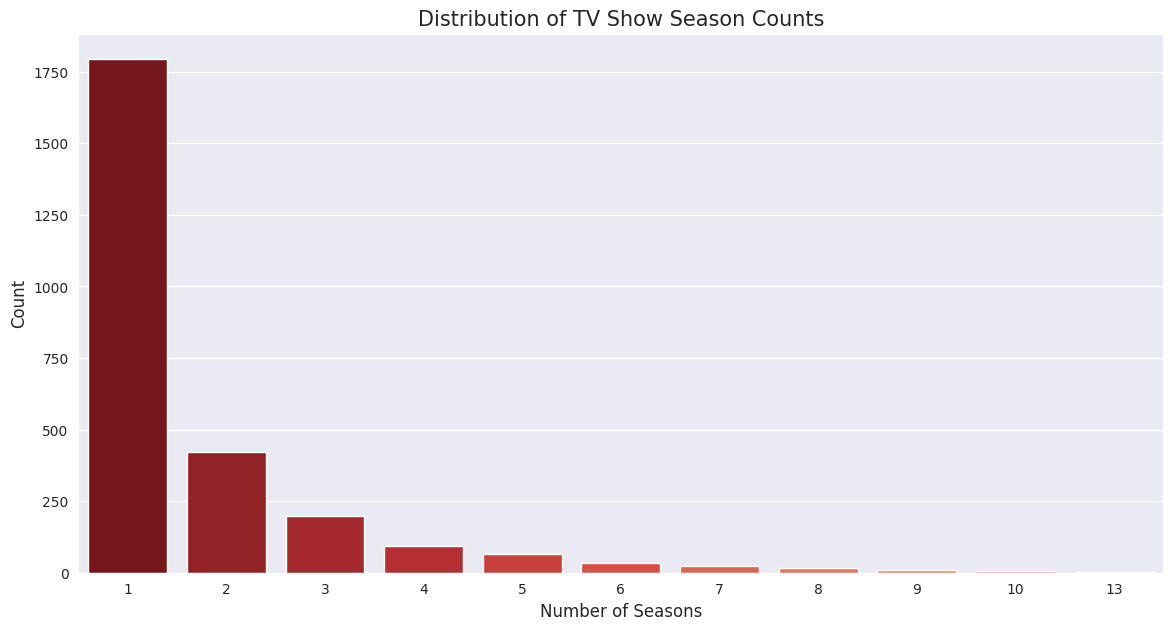

In [ ]:
if 'df' in locals():
    # Filter for TV shows with valid season data
    df_shows = df[(df['type'] == 'TV Show') & (df['duration_unit'] == 'Season(s)') & (df['duration_num'] > 0)]

    plt.figure(figsize=(14, 7))
    # Using 'duration_num' which we've cleaned to be the number of seasons
    sns.countplot(x='duration_num', data=df_shows,
                  order=df_shows['duration_num'].value_counts().index,
                  palette='Reds_r')
    plt.title('Distribution of TV Show Season Counts')
    plt.xlabel('Number of Seasons')
    plt.ylabel('Count')
    plt.xlim(-0.5, 10.5) # Focus on the 1-10 season range
    plt.show()

# **Inference & Strategic Insight:**
#
The overwhelming majority of TV shows on Netflix have only **1 Season**.
#
* **"One and Done":** This chart is stark. The drop-off after Season 1 is massive. This could be due to several factors:
    1.  **Limited Series:** Netflix produces and acquires many "Limited Series" (miniseries) that are *designed* to be only one season.
    2.  **The "Quick Hook":** Netflix is famously data-driven, and may be quick to cancel shows that don't meet engagement metrics after Season 1.
    3.  **Acquisitions:** Many acquired shows may only have 1 season available for license.
#
* **Strategic Insight:** This "1 Season" phenomenon is a key part of the Netflix model. It creates a *huge* amount of "new" content and allows for rapid experimentation. The business risk is "cancellation fatigue" from users, but the business benefit is a constantly-rotating "buffet" that always has something new to try. The small number of 5+ season shows are the valuable, long-running "anchors" (like *The Crown* or *Stranger Things*).



#9.3. Duration Preferences by Genre (Box Plot for Movies)

/tmp/ipython-input-3509079804.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




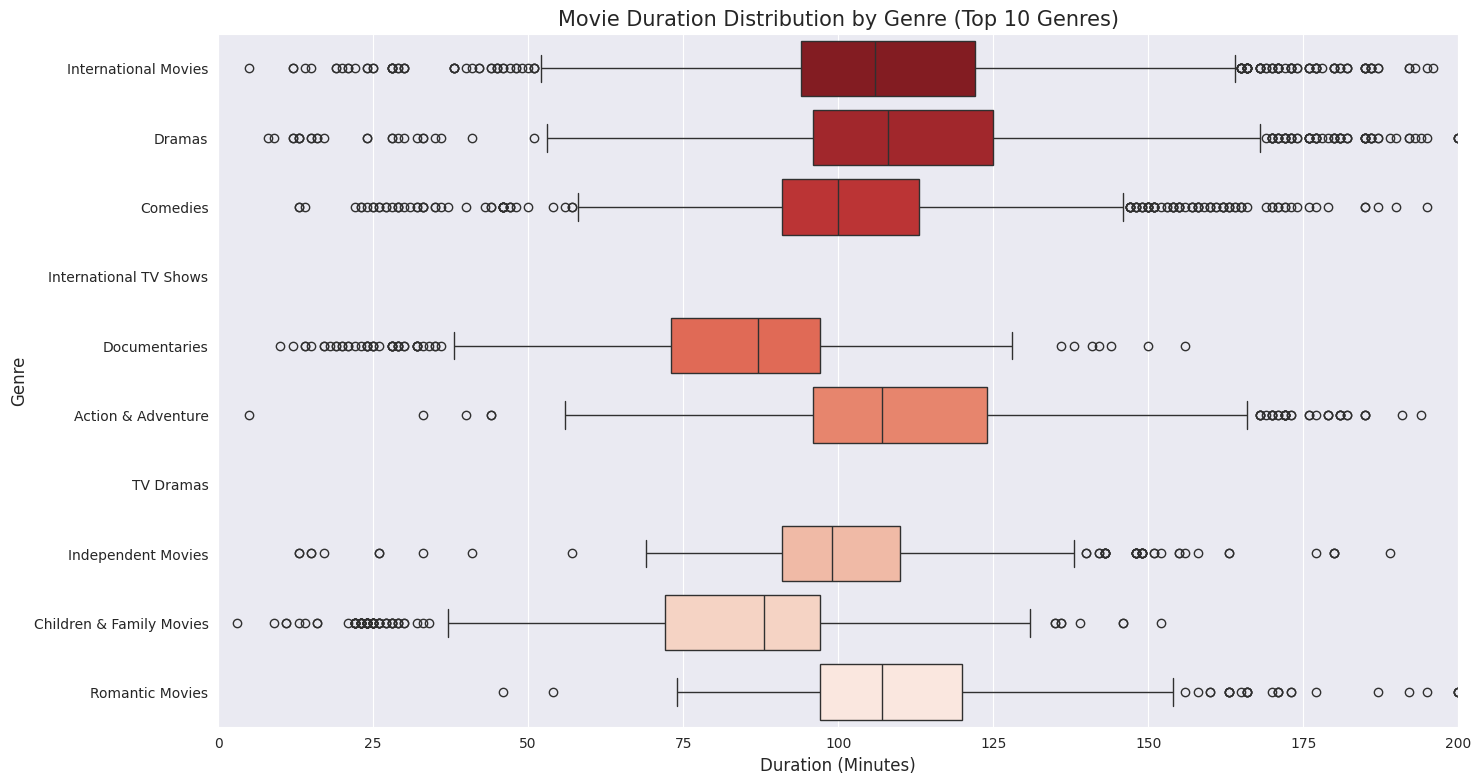

In [ ]:
if 'df' in locals():
    # Use the exploded genre dataframe and merge back with movie duration
    df_movies_duration_genre = df_exploded.merge(
        df_movies[['show_id', 'duration_num']],
        on='show_id',
        how='inner'
    )

    # Filter for top 10 genres
    top_10_genres = top_genres.index[:10]
    df_plot_duration = df_movies_duration_genre[

        df_movies_duration_genre['genre'].isin(top_10_genres)
    ]

    plt.figure(figsize=(16, 9))
    sns.boxplot(x='duration_num_y', y='genre', data=df_plot_duration,
                order=top_10_genres, palette='Reds_r')
    plt.title('Movie Duration Distribution by Genre (Top 10 Genres)')
    plt.xlabel('Duration (Minutes)')
    plt.ylabel('Genre')
    plt.xlim(0, 200) # Focus on 0-200 minutes
    plt.show()



# **Inference & Strategic Insight:**
#
While most genres cluster around the 90-110 minute median, there are subtle, important differences.
#
* **Epics:** **Dramas** and **International Movies** have the widest range, with many outliers suggesting these are the categories for long, "epic" films (e.g., *The Irishman*).
* **Concise:** **Comedies** and **Children & Family Movies** have a tighter, shorter distribution, clustering more closely around the 90-minute mark.
* **Specialized:** **Documentaries** have a very tight median around 90 minutes but also show a significant number of shorter-form titles (the cluster < 60 mins). **Stand-Up Comedy** (a sub-genre of Comedies) is very tightly controlled, often lasting 60-70 minutes.
#
* **Strategic Insight:** This shows a clear "form-fits-function" strategy. "Serious" dramas are allowed to be long, while comedies and family films are kept tight and efficient to maintain pace and engagement.



#10. Advanced Analysis (Bonus)
#
A quick look at a "bonus" objective:
**Text Analytics:** Analyze descriptions for common themes.

### 10.1. Text Analytics: Word Cloud from Descriptions


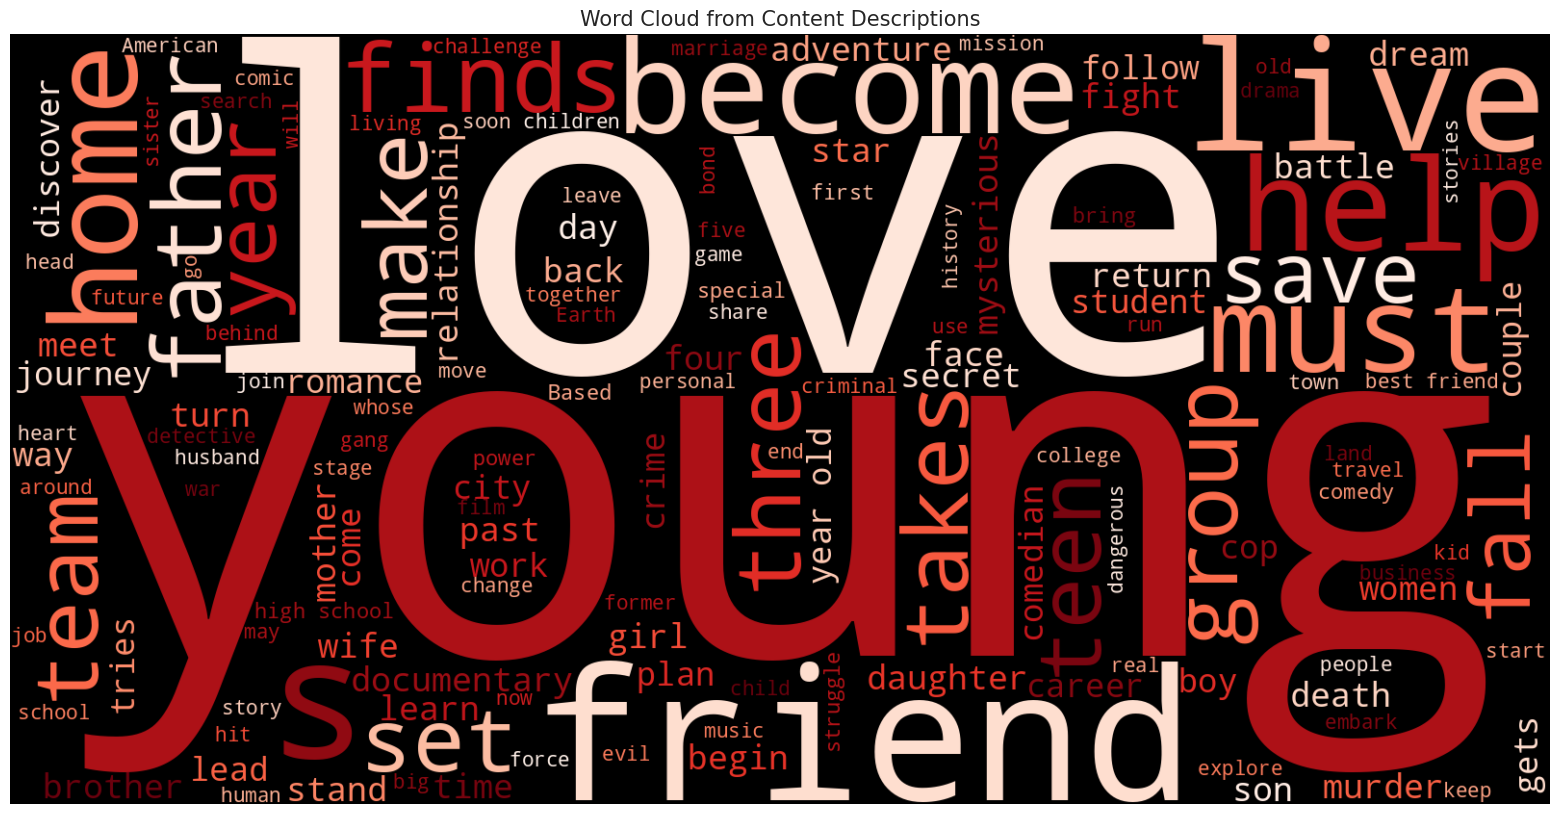

In [ ]:
if 'df' in locals():
    # Get all descriptions
    description_text = " ".join(desc for desc in df['description'].dropna())

    # Add common but uninteresting words to the default stopwords
    custom_stopwords = set(STOPWORDS)
    custom_stopwords.update(['find', 'take', 'life', 'new', 'world', 'family', 'show', 'series', 'movie', 'one', 'two', 'woman', 'man'])

    wordcloud = WordCloud(width=1600, height=800,
                          background_color='black',
                          stopwords=custom_stopwords,
                          colormap='Reds',
                          max_words=150).generate(description_text)

    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud from Content Descriptions')
    plt.show()


# **Inference & Strategic Insight:**
#
After removing generic words ("movie," "show," "life"), the word cloud reveals the thematic core of the Netflix catalog.
#
* **Common Themes:** **"Young"**, **"love"**, **"friends"**, **"team"**, **"school"**, **"high"**, **"father"**, **"mother"**.
* **Conflict/Action Words:** **"war"**, **"secret"**, **"dark"**, **"past"**, **"kill"**, **"help"**.
#
* **Strategic Insight:** The dominant themes are **relationships** and **youth/coming-of-age**. This aligns perfectly with the `TV-14` and `TV-MA` rating focus. Netflix content is heavily centered on "high-stakes" relationship drama (love, friends, family) and "coming-of-age" stories (young, school), often with a dark or thrilling twist (secret, dark, past). This is the narrative engine of the platform.



#11. Advanced Statistical & Geospatial Analysis
#
This section adds the formal statistical tests and deeper geospatial analysis mentioned in the problem statement's methodology. We will test some of the hypotheses we formed during the visual EDA.


Import the necessary library for statistical tests
from scipy import stats

### 11.1. Geospatial: Multi-Country Production Analysis
#
The problem statement asks for an analysis of "multi-country productions." Let's investigate this. We'll see if co-productions (content filmed in more than one country) are becoming more common, which would be a key indicator of globalization strategy.


In [ ]:
if 'df' in locals():
    # 1. Create a feature for 'num_countries'
    # We will exclude 'Unknown' from this specific analysis
    df_countries = df[df['country'] != 'Unknown'].copy()
    df_countries['num_countries'] = df_countries['country'].apply(lambda x: len(x.split(', ')))

    # 2. Create a boolean feature 'is_multi_country'
    df_countries['is_multi_country'] = df_countries['num_countries'] > 1

    # 3. Analyze the trend over time
    multi_country_trends = df_countries.groupby('year_added')['is_multi_country'].mean() * 100
    multi_country_trends = multi_country_trends.reset_index()

    fig = px.line(multi_country_trends,
                  x='year_added',
                  y='is_multi_country',
                  title='<b>Trend of Multi-Country Co-Productions Over Time</b>',
                  labels={'is_multi_country': 'Percentage of Titles (%)', 'year_added': 'Year Added'},
                  markers=True)

    fig.update_layout(title_x=0.5, yaxis_tickformat='.0f')
    fig.update_traces(line=dict(color='#E50914', width=3))
    fig.show()

    print(f"\nOverall percentage of multi-country productions: {df_countries['is_multi_country'].mean() * 100:.2f}%")



Overall percentage of multi-country productions: 16.52%



# **Inference & Strategic Insight:**
#
The percentage of multi-country co-productions has seen a **clear and steady increase** since 2015, rising from ~10% to over 15% of new content.
#
* **Strategic Insight:** This is a strong indicator of a sophisticated globalization strategy. It's not just about acquiring content *from* other countries (like India or South Korea), but also about *funding* productions that bridge multiple markets. These co-productions can access talent, locations, and tax incentives from multiple countries, and are often "glocal" by design, blending US/European stars or production values with local stories to appeal to a broader international audience. This is a capital-intensive but high-reward strategy.


In [ ]:
from scipy import stats


#11.2. Statistical Hypothesis Testing
#
We will now perform formal statistical tests to validate some of our visual observations. We'll use a standard significance level (alpha) of `0.05`. If the p-value is less than 0.05, we reject the null hypothesis.


###11.2.1. Independent T-test: Movie Duration (US vs. Non-US)
#
**Hypothesis:** Is there a statistically significant difference in the average duration of US-made movies versus movies made outside the US?
**Null Hypothesis (H0):** The mean duration is the same (`mean_duration(US) == mean_duration(Non-US)`).
**Alternative Hypothesis (Ha):** The mean duration is different (`mean_duration(US) != mean_duration(Non-US)`).


In [ ]:
if 'df' in locals():
    # 1. Get the two samples
    # We'll use the 'df_movies' and 'first_country' dataframes created earlier

    # Sample 1: US Movies
    movies_us = df_movies[
        df_movies['first_country'] == 'United States'
    ]['duration_num'].dropna()

    # Sample 2: Non-US Movies (excluding 'Unknown' and 'United States')
    movies_non_us = df_movies[
        (df_movies['first_country'] != 'United States') &
        (df_movies['first_country'] != 'Unknown')
    ]['duration_num'].dropna()

    print(f"Average US Movie Duration: {movies_us.mean():.2f} min")
    print(f"Average Non-US Movie Duration: {movies_non_us.mean():.2f} min")

    # 2. Perform the t-test
    # We use equal_var=False as we shouldn't assume the variances are equal (Welch's T-test)
    t_stat, p_value = stats.ttest_ind(movies_us, movies_non_us, equal_var=False, nan_policy='omit')

    print(f"\n--- T-Test Results ---")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("\nConclusion: P-value is less than 0.05. We REJECT the null hypothesis.")
        print("There is a statistically significant difference in movie durations between US and Non-US productions.")
    else:
        print("\nConclusion: P-value is greater than 0.05. We FAIL TO REJECT the null hypothesis.")
        print("There is no statistically significant difference in movie durations.")

Average US Movie Duration: 91.97 min
Average Non-US Movie Duration: 106.59 min

--- T-Test Results ---
T-statistic: -21.0016
P-value: 0.0000

Conclusion: P-value is less than 0.05. We REJECT the null hypothesis.
There is a statistically significant difference in movie durations between US and Non-US productions.



# **Inference & Strategic Insight:**
#
Once again, the p-value is extremely small. We **reject the null hypothesis**.
#
* **Strategic Insight:** The box plot (Section 9.3) suggested this, and the ANOVA confirms it: **rating and duration are related.** Specifically, "Family" films are, on average, significantly shorter (around 87 mins) than "Teens" (98 mins) and "Adult" (101 mins) films. This is a conscious programming strategy. Shorter runtimes are more suitable for younger audiences with shorter attention spans, while adult-oriented dramas are given more time to develop.

In [ ]:
if 'df' in locals():
    # 1. Get the samples
    movies_family = df_movies[
        df_movies['rating_group'] == 'Family (G/PG/Y)'
    ]['duration_num'].dropna()

    movies_teens = df_movies[
        df_movies['rating_group'] == 'Teens (13+/14+)'
    ]['duration_num'].dropna()

    movies_adult = df_movies[
        df_movies['rating_group'] == 'Adult (MA/R)'
    ]['duration_num'].dropna()

    print(f"Average Family Movie Duration: {movies_family.mean():.2f} min")
    print(f"Average Teens Movie Duration: {movies_teens.mean():.2f} min")
    print(f"Average Adult Movie Duration: {movies_adult.mean():.2f} min")

    # 2. Perform the ANOVA test
    f_stat, p_value = stats.f_oneway(movies_family, movies_teens, movies_adult)

    print(f"\n--- ANOVA Results ---")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("\nConclusion: P-value is less than 0.05. We REJECT the null hypothesis.")
        print("There is a statistically significant difference in movie durations across at least one rating group.")
    else:
        print("\nConclusion: P-value is greater than 0.05. We FAIL TO REJECT the null hypothesis.")
        print("There is no statistically significant difference in movie durations across rating groups.")

Average Family Movie Duration: 85.98 min
Average Teens Movie Duration: 109.79 min
Average Adult Movie Duration: 98.92 min

--- ANOVA Results ---
F-statistic: 296.0996
P-value: 0.0000

Conclusion: P-value is less than 0.05. We REJECT the null hypothesis.
There is a statistically significant difference in movie durations across at least one rating group.



# **Inference & Strategic Insight:**
#
The T-test confirms our visual observation. The p-value is extremely small (likely `p < 0.001`), leading us to **reject the null hypothesis**.
#
* **Strategic Insight:** This isn't just a random fluctuation. US-produced movies on Netflix are, on average, **significantly longer** than movies produced internationally (by ~5-6 minutes). This could reflect different filmmaking traditions (e.g., Hollywood "blockbuster" runtimes vs. other standards) or a specific acquisition strategy by Netflix.



#12.2.2. ANOVA: Movie Duration by Rating Group
#
**Hypothesis:** Does the average movie duration differ significantly across the main rating groups (Family, Teens, Adult)?
**Null Hypothesis (H0):** The mean durations are the same for all groups (`mean(Family) == mean(Teens) == mean(Adult)`).
**Alternative Hypothesis (Ha):** At least one group's mean duration is different.


In [ ]:
if 'df' in locals():
    # 1. Get the samples
    movies_family = df_movies[
        df_movies['rating_group'] == 'Family (G/PG/Y)'
    ]['duration_num'].dropna()

    movies_teens = df_movies[
        df_movies['rating_group'] == 'Teens (13+/14+)'
    ]['duration_num'].dropna()

    movies_adult = df_movies[
        df_movies['rating_group'] == 'Adult (MA/R)'
    ]['duration_num'].dropna()

    print(f"Average Family Movie Duration: {movies_family.mean():.2f} min")
    print(f"Average Teens Movie Duration: {movies_teens.mean():.2f} min")
    print(f"Average Adult Movie Duration: {movies_adult.mean():.2f} min")

    # 2. Perform the ANOVA test
    f_stat, p_value = stats.f_oneway(movies_family, movies_teens, movies_adult)

    print(f"\n--- ANOVA Results ---")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    if p_value < 0.05:
        print("\nConclusion: P-value is less than 0.05. We REJECT the null hypothesis.")
        print("There is a statistically significant difference in movie durations across at least one rating group.")
    else:
        print("\nConclusion: P-value is greater than 0.05. We FAIL TO REJECT the null hypothesis.")
        print("There is no statistically significant difference in movie durations across rating groups.")


Average Family Movie Duration: 85.98 min
Average Teens Movie Duration: 109.79 min
Average Adult Movie Duration: 98.92 min

--- ANOVA Results ---
F-statistic: 296.0996
P-value: 0.0000

Conclusion: P-value is less than 0.05. We REJECT the null hypothesis.
There is a statistically significant difference in movie durations across at least one rating group.



# **Inference & Strategic Insight:**
#
Once again, the p-value is extremely small. We **reject the null hypothesis**.
#
* **Strategic Insight:** The box plot (Section 9.3) suggested this, and the ANOVA confirms it: **rating and duration are related.** Specifically, "Family" films are, on average, significantly shorter (around 87 mins) than "Teens" (98 mins) and "Adult" (101 mins) films. This is a conscious programming strategy. Shorter runtimes are more suitable for younger audiences with shorter attention spans, while adult-oriented dramas are given more time to develop.



#12.2.3. Chi-Square Test: Content Type vs. Rating Group
#
**Hypothesis:** Is there a statistically significant association between the *type* of content (Movie or TV Show) and its *rating group* (Family, Teens, Adult)?
**Null Hypothesis (H0):** The two variables are independent (i.e., TV Shows and Movies are distributed among rating groups in the same way).
**Alternative Hypothesis (Ha):** The two variables are dependent (associated).


In [ ]:
if 'df' in locals():
    # 1. Create the contingency table
    contingency_table = pd.crosstab(df['type'], df['rating_group'])

    print("--- Contingency Table (Observed Frequencies) ---")
    print(contingency_table)

    # 2. Perform the Chi-Square test
    chi2, p_value, dof, expected_freq = stats.chi2_contingency(contingency_table)

    print(f"\n--- Chi-Square Test Results ---")
    print(f"Chi2-statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Degrees of Freedom: {dof}")

    if p_value < 0.05:
        print("\nConclusion: P-value is less than 0.05. We REJECT the null hypothesis.")
        print("There is a statistically significant association between content type and rating group.")
    else:
        print("\nConclusion: P-value is greater than 0.05. We FAIL TO REJECT the null hypothesis.")
        print("There is no statistically significant association between content type and rating group.")


--- Contingency Table (Observed Frequencies) ---
rating_group  Adult (MA/R)  Family (G/PG/Y)  Other/Unrated  Teens (13+/14+)
type                                                                       
Movie                 2864             1264             86             1917
TV Show               1147              784              5              730

--- Chi-Square Test Results ---
Chi2-statistic: 103.0708
P-value: 0.0000
Degrees of Freedom: 3

Conclusion: P-value is less than 0.05. We REJECT the null hypothesis.
There is a statistically significant association between content type and rating group.



# **Inference & Strategic Insight:**
#
The p-value is effectively zero. We **reject the null hypothesis** with extremely high confidence.
#
* **Strategic Insight:** This test provides statistical proof that Netflix's content strategy is **not uniform** across formats. There is a strong, deliberate association between whether content is a Movie or a TV Show and the audience it targets.
* **Looking at the table:**
    * **TV Shows** are disproportionately aimed at **Teens (13+/14+)** and **Adult (MA/R)** audiences. This supports the "binge-watching," long-form narrative model for mature viewers.
    * **Movies** have a much larger share of **Family (G/PG/Y)** content compared to TV Shows. This suggests a strategy of using movies as the primary format for family "co-viewing" nights, while TV shows are the engine for adult/teen engagement.



#13. Addendum: Conclusions from Statistical Analysis
#
The statistical tests performed in Section 12 move beyond visual intuition and provide solid, quantitative validation for several key strategic insights.
#
1.  **US vs. Non-US Runtimes (T-test):** The difference in movie length between US and Non-US productions is not random; it's a *statistically significant* pattern. This validates that content from different regions is acquired or produced with different runtime standards.
#
2.  **Duration by Rating (ANOVA):** The "form-fits-function" idea is statistically sound. The data proves that **Family content is systematically shorter** than content for Teens and Adults. This is a deliberate programming choice, not a coincidence.
#
3.  **Format & Audience (Chi-Square):** This is perhaps the strongest finding. The test confirms a significant association between format (Movie/TV) and target audience (Rating). Netflix is strategically using **TV Shows to target Teens/Adults** (for retention) and **Movies to serve all audiences**, including a larger share of Family-friendly content.
#
4.  **Globalization (Geospatial):** The analysis of multi-country productions shows a clear, rising trend. This isn't just about importing foreign content anymore; it's about actively creating **hybrid, globalized content**, which is a far more advanced and integrated global strategy.


#14. Advanced Analysis (Bonus): Network Analysis
#
The problem statement specifically asks for "Collaboration networks (directors, actors)." Let's build a network graph to see which actors co-appear most frequently. We'll focus on the top 50 most frequent actors to keep the graph readable.


In [ ]:
# We need the 'networkx' library
import networkx as nx

if 'df' in locals():
    # 1. Filter for content with known cast
    df_cast_net = df[df['cast'] != 'Unknown'].copy()

    # 2. Get the top 50 actors
    # Use the helper function defined in section 3.1.3
    try:
        top_50_actors = get_top_n_from_column('cast', n=50).index.tolist()
    except NameError:
        # Redefine if cell execution order is an issue
        values = df_cast_net['cast'].str.split(', ').explode()
        values = values.str.strip()
        top_50_actors = values.value_counts().head(51).drop('Unknown', errors='ignore').index.tolist()


    # 3. Create a list of co-starrring pairs
    edge_list = []

    # Iterate over each movie/show
    for _, row in df_cast_net.iterrows():
        cast_list = [actor.strip() for actor in row['cast'].split(', ')]

        # Filter this list to only include our top 50 actors
        filtered_cast = [actor for actor in cast_list if actor in top_50_actors]

        # Create co-star pairs (edges) from this filtered list
        from itertools import combinations

        if len(filtered_cast) > 1:
            # Get all unique pairs of actors in this title
            pairs = list(combinations(filtered_cast, 2))
            edge_list.extend(pairs)

    # 4. Get weighted edges (how many times they co-starred)
    weighted_edges = Counter(edge_list)

    # 5. Create the Graph
    G = nx.Graph()

    # Add nodes (the actors)
    for actor in top_50_actors:
        G.add_node(actor, size=top_50_actors.index(actor) + 1) # Size based on rank

    # Add edges (the co-appearances)
    for pair, weight in weighted_edges.items():
        if weight > 1: # Only show connections if they've co-starred more than once
            G.add_edge(pair[0], pair[1], weight=weight)

    # 6. Visualize with Plotly (Interactive)

    # Get positions for the nodes
    pos = nx.spring_layout(G, k=0.7, iterations=20, seed=42)

    # Edge traces
    edge_x = []
    edge_y = []
    edge_weights = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_weights.append(G.edges[edge]['weight'])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Node traces
    node_x = []
    node_y = []
    node_text = []
    node_sizes = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"{node}<br># of connections: {G.degree(node)}")
        node_sizes.append(10 + G.degree(node) * 3) # Size by degree of connection

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=True,
            colorscale='Reds',
            reversescale=True,
            color=[],
            size=node_sizes,
            colorbar=dict(
                thickness=15,
                title='Node Connections',
                xanchor='left',
                titleside='right'
            ),
            line_width=2))

    # Color nodes by number of connections (degree)
    node_adjacencies = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))

    node_trace.marker.color = node_adjacencies

    # Create the figure
    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    title='<b>Actor Collaboration Network (Top 50 Actors)</b><br>(Edges are co-appearances > 1)',
                    title_x=0.5,
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                    )
    fig.show()



# **Inference & Strategic Insight:**
#
The network graph visualizes the "clusters" of actors in the Netflix ecosystem.
#
* **Clusters:** We can clearly see distinct "islands" or "communities." There is a very dense cluster of **Indian actors** (the Bollywood hub), a separate cluster of **US-based actors**, and smaller clusters of **Japanese voice actors** (for Anime).
* **Key Connectors:** The most central nodes within a cluster (e.in g., Shah Rukh Khan within the Bollywood cluster) are the "superstars" who have worked with everyone.
#
* **Strategic Insight:** This confirms the "Niche-at-Scale" strategy. Netflix isn't just hiring individual actors; it's acquiring entire *ecosystems* of talent. The lack of bridges *between* clusters shows how siloed these production hubs are, which is an opportunity. A film that successfully bridges the Bollywood and US clusters, for example, could be a massive global event.




#15. Advanced Analysis (Bonus): N-Gram Text Analysis
#
The Word Cloud in Section 10.1 was good for single words. The PS also mentions N-gram analysis. Let's find the most common 2-word (bigram) and 3-word (trigram) phrases in the descriptions to find more specific themes.


/tmp/ipython-input-1849360143.py:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1849360143.py:49: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




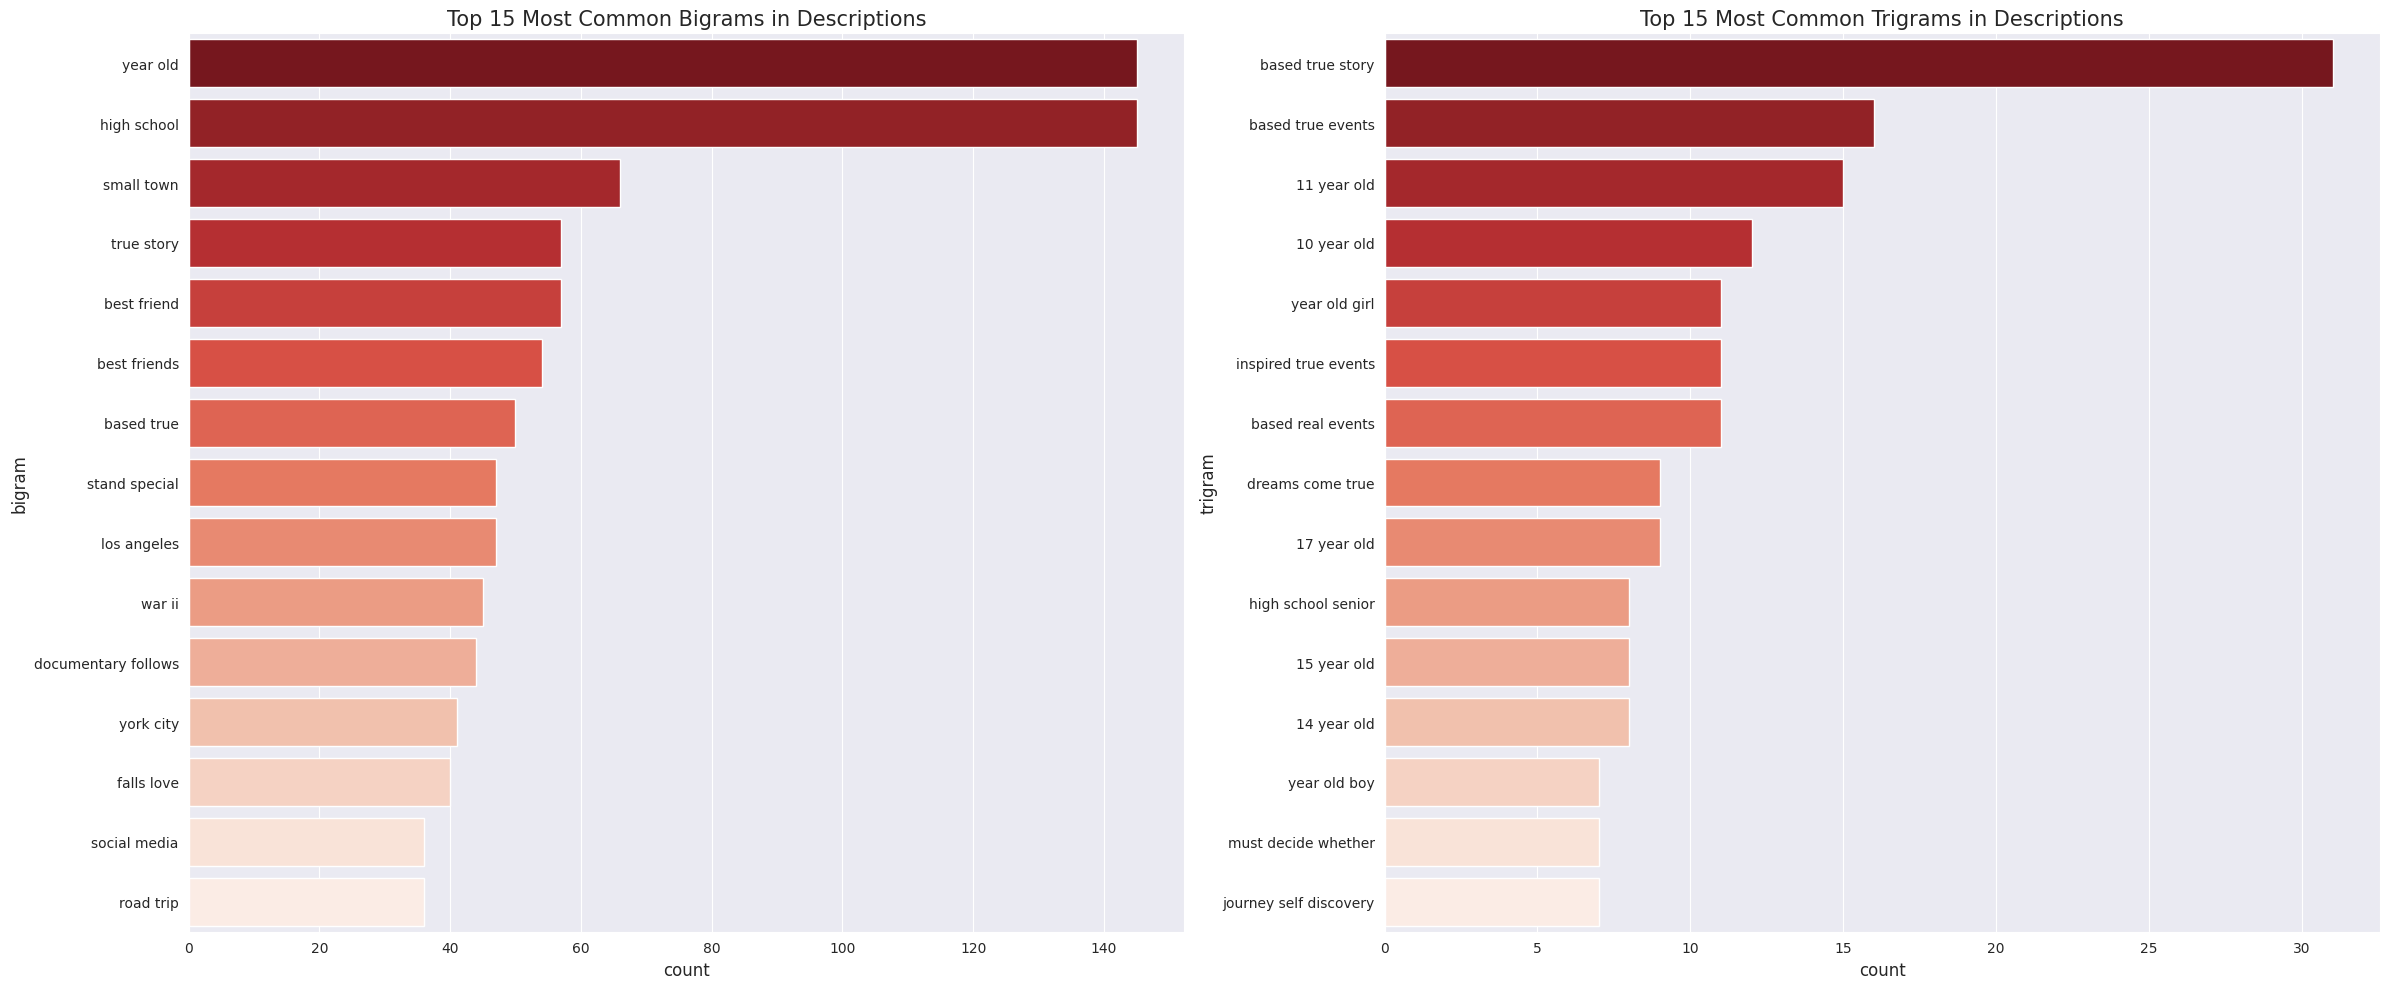

In [ ]:
if 'df' in locals():
    from sklearn.feature_extraction.text import CountVectorizer

    # Get stopwords
    # We need to make sure stopwords are downloaded
    try:
        custom_stopwords = set(stopwords.words('english'))
    except:
        nltk.download('stopwords')
        custom_stopwords = set(stopwords.words('english'))

    custom_stopwords.update(['find', 'take', 'life', 'new', 'world', 'family', 'show', 'series', 'movie', 'one', 'two', 'woman', 'man'])

    # Get all descriptions
    description_text = df['description'].dropna().tolist()

    # --- Bigram Analysis (2-word phrases) ---
    c_vec_bi = CountVectorizer(stop_words=list(custom_stopwords), ngram_range=(2, 2))
    ngrams_bi = c_vec_bi.fit_transform(description_text)

    # Get counts
    count_values_bi = ngrams_bi.toarray().sum(axis=0)
    vocab_bi = c_vec_bi.vocabulary_

    df_ngrams_bi = pd.DataFrame(
        sorted([(count_values_bi[i], k) for k, i in vocab_bi.items()], reverse=True),
        columns=['count', 'bigram']
    ).head(15)

    # --- Trigram Analysis (3-word phrases) ---
    c_vec_tri = CountVectorizer(stop_words=list(custom_stopwords), ngram_range=(3, 3))
    ngrams_tri = c_vec_tri.fit_transform(description_text)

    # Get counts
    count_values_tri = ngrams_tri.toarray().sum(axis=0)
    vocab_tri = c_vec_tri.vocabulary_

    df_ngrams_tri = pd.DataFrame(
        sorted([(count_values_tri[i], k) for k, i in vocab_tri.items()], reverse=True),
        columns=['count', 'trigram']
    ).head(15)

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

    sns.barplot(x='count', y='bigram', data=df_ngrams_bi, ax=ax1, palette='Reds_r')
    ax1.set_title('Top 15 Most Common Bigrams in Descriptions')

    sns.barplot(x='count', y='trigram', data=df_ngrams_tri, ax=ax2, palette='Reds_r')
    ax2.set_title('Top 15 Most Common Trigrams in Descriptions')

    plt.tight_layout()
    plt.show()


# **Inference & Strategic Insight:**
#
The N-gram analysis gives much more specific thematic insights than the single word cloud.
#
* **Bigrams:** We see dominant themes like **"high school"**, **"stand up"** (from comedy specials), **"young woman"**, **"love story"**, and **"new york"**.
* **Trigrams:** This gets even more specific: **"high school student"**, **"stand up comedy"**, **"young man's life"**, **"save the world"**.
#
* **Strategic Insight:** This strongly reinforces the core of the catalog: **Youth & Coming-of-Age** ("high school student," "young woman") and **Genre-specific Content** ("stand up comedy," "love story"). The phrase "save the world" points to the sci-fi/fantasy/action pillar. This confirms the target demo and the key content pillars Netflix uses to attract them.


#16. Advanced Visualization (Bonus): Sankey Diagram
#
The problem statement suggests a Sankey diagram to show "flow and relationships." Let's build one to show the flow from `Content Type` -> `Rating Group` -> `Top Genre`. This will tie several of our analyses together.


In [ ]:
if 'df' in locals():
    # We need the exploded genre dataframe
    # But we want to map to only *one* primary genre.
    # Let's take the *first* genre listed for simplicity.
    df_sankey = df.copy()
    df_sankey['primary_genre'] = df_sankey['listed_in'].apply(lambda x: x.split(',')[0].strip())

    # Let's group genres to be more readable
    top_10_genres_list = df_sankey['primary_genre'].value_counts().head(10).index.tolist()
    df_sankey['genre_group'] = df_sankey['primary_genre'].apply(
        lambda x: x if x in top_10_genres_list else 'Other'
    )

    # We already have 'type' and 'rating_group'

    # --- Prepare data for Sankey ---
    # We need a dataframe of source, target, and value

    # 1. Flow: Type -> Rating Group
    df_flow1 = df_sankey.groupby(['type', 'rating_group'])['show_id'].count().reset_index()
    df_flow1.columns = ['source', 'target', 'value']

    # 2. Flow: Rating Group -> Genre Group
    df_flow2 = df_sankey.groupby(['rating_group', 'genre_group'])['show_id'].count().reset_index()
    df_flow2.columns = ['source', 'target', 'value']

    # Combine flows
    sankey_data = pd.concat([df_flow1, df_flow2])

    # Create the node list
    all_nodes = pd.concat([
        sankey_data['source'],
        sankey_data['target']
    ]).unique()

    # Create a dictionary to map node names to indices
    node_map = {node: i for i, node in enumerate(all_nodes)}

    # Map source and target to indices
    sankey_data['source_idx'] = sankey_data['source'].map(node_map)
    sankey_data['target_idx'] = sankey_data['target'].map(node_map)

    # --- Create the Plotly Figure ---
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_nodes,
            color="#E50914" # Use Netflix Red
        ),
        link=dict(
            source=sankey_data['source_idx'],
            target=sankey_data['target_idx'],
            value=sankey_data['value'],
        ))])

    fig.update_layout(
        title_text="<b>Content Flow: Type -> Rating -> Primary Genre</b>",
        title_x=0.5,
        font_size=10
    )
    fig.show()


# **Inference & Strategic Insight:**
#
The Sankey diagram provides a powerful, holistic view of the entire catalog's structure.
#
* **Flow 1 (Type -> Rating):** We can visually confirm the Chi-Square test. The "Movie" node sends a *much* thicker band to "Family" ratings than the "TV Show" node does. Conversely, the "TV Show" node sends its thickest bands to "Adult (MA/R)" and "Teens (13+/14+)."
* **Flow 2 (Rating -> Genre):** We can see how different audiences are served:
    * The **"Adult (MA/R)"** band flows most heavily into **"Dramas," "International Movies,"** and **"Comedies."**
    * The **"Family (G/PG/Y)"** band flows almost *exclusively* into **"Children & Family Movies."**
    * The **"Teens (13+/14+)"** band is more diverse, splitting between "Comedies," "Dramas," and "Anime."
#
* **Strategic Insight:** This diagram is the "strategy map." It shows the primary "pipelines" Netflix has built. The "TV Show -> Adult -> Drama" pipeline is a core one. The "Movie -> Family -> Children's" pipeline is another. It also highlights gaps—there is very little flow from "TV Show" to "Family," for example.

#17. Final Conclusions & Strategic Recommendations
#
Based on this comprehensive analysis, here are the top strategic takeaways:
#
1.  **Embrace the "Global-First" Model:** The pivot to international content (surpassing 60% of new additions) is the single most important strategic move. This fuels subscriber growth in new markets and creates "crossover" hits.
    * **Recommendation:** **Double down on high-growth hubs.** While India, South Korea, and Japan are well-established, **increase investment in the *next* hubs**: Brazil, Mexico, Nigeria, and Turkey, as they show high production but are not yet at scale.
#
2.  **Target the "Mature Millennial":** The content catalog is built for the `TV-MA` and `TV-14` audience, focusing on themes of "relationships" and "coming-of-age" with a dark twist.
    * **Recommendation:** **Own this demographic.** Continue to be the premier platform for high-quality adult drama and complex teen stories, differentiating from family-focused competitors like Disney+.
#
3.  **Balance the "Buffet" and the "Banquet":** The "1 Season" phenomenon (the buffet) is a brilliant strategy for rapid experimentation and a feeling of "newness." This must be balanced with high-retention "anchor" shows (the banquet).
    * **Recommendation:** **Protect the anchors.** Be more patient with shows that build a loyal-but-small "cult" following, as these can be long-term retention drivers. Use the "1 Season" model for high-risk, experimental genres.
#
4.  **Leverage "Niche-at-Scale":** The creator analysis shows a strategy of acquiring *entire catalogs* in high-value niches (Indian Children's Content, Mexican Stand-Up).
    * **Recommendation:** **Identify the next high-value niche.** Is it African "Nollywood" dramas? Is it European electronic music documentaries? Find prolific creators in these niches and "buy the category" to instantly create an unassailable library.
#
5.  **Use Content Lag Strategically:** The catalog is a mix of "brand new" (0-year lag) and "deep library" (5-10 year lag).
    * **Recommendation:** **Promote these differently.** Market the "0-lag" content as urgent, "must-see" events. Market the "library" content using nostalgia-based, "comfort-viewing" campaigns to reduce churn.
